In [11]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import warnings
from tqdm import tqdm
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import pickle 
device = "cuda" if torch.cuda.is_available() else "cpu" 

In [214]:
def Load_preprocessed_data():
    
    adata = sc.datasets.pbmc3k()
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :]
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
    sc.pp.scale(adata, max_value=10)
    df = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var.index)

    # Scale each variable between 0 and 1 where zero is the minimum value of all observations and one the max
    max_vals = np.max(df, axis=0)
    min_vals = np.min(df, axis=0)
    scaled_df = (df - np.min(min_vals)) / (np.max(max_vals) - np.min(min_vals))
    adata.X = scaled_df.to_numpy()
    adata.X = np.float32(adata.X)

    sc.tl.pca(adata, svd_solver='arpack')

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(adata,resolution=0.6, key_added="leiden_pca")
    sc.tl.umap(adata)
    
    return adata
adata = Load_preprocessed_data()

In [12]:
### model based on: https://sannaperzon.medium.com/paper-summary-variational-autoencoders-with-pytorch-implementation-1b4b23b1763a
### and https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

def ModelsNN(dim_encoder_decoder=2048,dim_hidden=1024,dim_latent=40):
    class AE(nn.Module):
        def __init__(self, dim_encoder_decoder, dim_hidden, dim_latent):
            super(AE , self).__init__()
            self.encoder = nn.Sequential(                       # sequential operation of the following code:
                nn.Linear(dim_encoder_decoder, dim_hidden),           # decoding laten layer 
                nn.ReLU(),   
                nn.Linear(dim_hidden, dim_latent),
            )

            self.decoder = nn.Sequential(                             # sequential operation of the following code:
                nn.Linear(dim_latent, dim_hidden),                    # decoding laten layer
                nn.ReLU(),                                            # activation function f(x) = max(0, x)
                nn.Linear(dim_hidden, dim_encoder_decoder),           # reconstruction of image 
                nn.Sigmoid()                                     # rescale values between ]0,1[ by the sigmoidal function
            )

        def forward(self, x):                                         # 
            latent = self.encoder(x)
            decoded = self.decoder(latent)
            return latent, decoded                           # return the latent vector, decoded vector 


    model_AE = AE(dim_encoder_decoder, dim_hidden, dim_latent).to(device)
    
    class VAE(nn.Module):
        def __init__(self, dim_encoder_decoder, dim_hidden, dim_latent):
            super(VAE , self).__init__()
            
            self.encoder_layer = nn.Sequential(                       # sequential operation of the following code:
                nn.Linear(dim_encoder_decoder, dim_hidden),           # decoding laten layer 
                nn.ReLU(),                                            # activation function
            )
            
            self.hidden_to_mu = nn.Linear(dim_hidden, dim_latent)     # hidden layer in dim_latent for mu
            self.hidden_to_sigma = nn.Linear(dim_hidden, dim_latent)  # hidden layer in dim_latent for sigma

            self.decoder = nn.Sequential(                             # sequential operation of the following code:
                nn.Linear(dim_latent, dim_hidden),                    # decoding laten layer 
                nn.ReLU(),                                            # activation function f(x) = max(0, x)
                nn.Linear(dim_hidden, dim_encoder_decoder),           # reconstruction of image 
                nn.Sigmoid() #nn.Softmax()                            # rescale values between ]0,1[ by the sigmoidal function
            )

        def encoder(self, x):
            hidden_layer = self.encoder_layer(x)                      #
            mu = self.hidden_to_mu(hidden_layer)                      # get the mean
            sigma = self.hidden_to_sigma(hidden_layer)                # get the standard devation
            return mu , sigma                                         # return the encoded 


        def forward(self, x):                                         # 
            mu, sigma = self.encoder(x)                               # compute the variance and mean of a reduced dim
            epsilon = torch.randn_like(sigma)                         # random noice ### Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1
            z = mu + sigma*epsilon                                    # reparametrization # compute latent layer from reduced dim of mu and sigma and some random noice
            decoded = self.decoder(z)                                 # decode latent layer
            return decoded , mu, sigma , z                            # return the decoded vector, mean, standard devation, latent vector

    model_VAE = VAE(dim_encoder_decoder, dim_hidden, dim_latent).to(device)

    return model_AE, model_VAE

In [13]:
def Model_Training(model="AE",learning_rate=5e-5,epochs=[300],batch_size=24,dim=[adata.X.shape[1],1024,40],Train_data=adata.X, kl_scaling=1e-3, seed = 42):
    
    torch.manual_seed(seed)
    
    model_AE, model_VAE = ModelsNN(dim_encoder_decoder=dim[0],dim_hidden=dim[1],dim_latent=dim[2])
    
    loss_fn = nn.MSELoss( reduction='sum')
    
    adata_tensor = torch.tensor(adata.X).to(device)
    adata_tensor_loader = DataLoader(dataset=adata_tensor, batch_size=batch_size, shuffle=True)
    
    if model == "AE":

        optimizer = torch.optim.Adam(model_AE.parameters(),lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.75, patience=10,verbose=True)
        
        for n_epochs in epochs:

            loop = tqdm(np.arange(0,n_epochs))
            for epoch in loop:
                
                losses = []
                
                for batch , X in enumerate(adata_tensor_loader):
                    X = X.to(device)
                    latent , pred  = model_AE(X)
                    loss = loss_fn(pred, X)
                    
                    losses.append(loss.item())
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                loop.set_description(f"last found loss: {round(sum(losses),4)}; Total progress")
                mean_loss = sum(losses)/len(losses)
                scheduler.step(mean_loss)
        
        return model_AE
    
    elif model == "VAE":
        
        optimizer = torch.optim.Adam(model_VAE.parameters(),lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.75, patience=10,verbose=True)

        for n_epochs in epochs:
            loss_list_kl = []
            loss_list_re = []

            loop = tqdm(np.arange(0,n_epochs))
            for epoch in loop:
                
                losses = []
                losses_re = []
                losses_kl = []
                
                for batch , X in enumerate(adata_tensor_loader):
                    X = X.to(device)
                    decoded , mu, sigma , z  = model_VAE(X)
                    re_loss = loss_fn(decoded, X)
                    kl_div = - kl_scaling*torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
                    loss = re_loss + kl_div
                    
                    losses.append(loss.item())
                    losses_re.append(re_loss.item())
                    losses_kl.append(kl_div.item())
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                loss_list_re.append(sum(losses_re))
                loss_list_kl.append(sum(losses_kl))
                
                loop.set_description(f"last found loss: {round(sum(losses),1)}, RE {round(sum(losses_re),1)}, KL {round(sum(losses_kl),1)}; Total progress")
                mean_loss = sum(losses)/len(losses)
                scheduler.step(mean_loss)
                
        return model_VAE

    else:
        print(f"diffine model by the name 'AE' or 'VAE' and your input is: {model}")

In [16]:
for seed in np.arange(0,20,1):
    print(seed)
    model = Model_Training(model="AE",
                              learning_rate=5e-5,
                              epochs=[300],
                              batch_size=24,
                              dim=[adata.X.shape[1],1024,40],
                              Train_data=adata.X,
                              kl_scaling=None,
                              seed=seed
                             )
    
    FILE = f"model_AE_seed{seed}.pth"
    
    torch.save(model.state_dict(),FILE)

0


last found loss: 20119.047; Total progress: 100%|██████████| 300/300 [07:10<00:00,  1.43s/it] 


1


last found loss: 20078.4465; Total progress: 100%|██████████| 300/300 [07:08<00:00,  1.43s/it]


2


last found loss: 19959.5787; Total progress: 100%|██████████| 300/300 [07:13<00:00,  1.44s/it]


3


last found loss: 20094.9228; Total progress: 100%|██████████| 300/300 [07:07<00:00,  1.42s/it]


4


last found loss: 20131.7209; Total progress: 100%|██████████| 300/300 [07:04<00:00,  1.42s/it]


5


last found loss: 19909.5258; Total progress: 100%|██████████| 300/300 [07:10<00:00,  1.44s/it]


6


last found loss: 19975.4661; Total progress: 100%|██████████| 300/300 [07:20<00:00,  1.47s/it]


7


last found loss: 20074.8958; Total progress: 100%|██████████| 300/300 [07:11<00:00,  1.44s/it]


8


last found loss: 19833.5139; Total progress: 100%|██████████| 300/300 [07:30<00:00,  1.50s/it]


9


last found loss: 19910.3977; Total progress: 100%|██████████| 300/300 [06:54<00:00,  1.38s/it]


10


last found loss: 20170.762; Total progress: 100%|██████████| 300/300 [07:18<00:00,  1.46s/it] 


11


last found loss: 20049.6655; Total progress: 100%|██████████| 300/300 [07:03<00:00,  1.41s/it]


12


last found loss: 20119.3314; Total progress: 100%|██████████| 300/300 [07:55<00:00,  1.59s/it]


13


last found loss: 19948.7754; Total progress: 100%|██████████| 300/300 [07:43<00:00,  1.54s/it]


14


last found loss: 20096.3278; Total progress: 100%|██████████| 300/300 [07:38<00:00,  1.53s/it]


15


last found loss: 19974.1158; Total progress: 100%|██████████| 300/300 [07:57<00:00,  1.59s/it]


16


last found loss: 19926.1203; Total progress: 100%|██████████| 300/300 [07:35<00:00,  1.52s/it]


17


last found loss: 20053.9253; Total progress: 100%|██████████| 300/300 [07:42<00:00,  1.54s/it]


18


last found loss: 20041.5481; Total progress: 100%|██████████| 300/300 [07:43<00:00,  1.55s/it]


19


last found loss: 20200.2689; Total progress: 100%|██████████| 300/300 [07:36<00:00,  1.52s/it]


In [150]:
for seed in np.arange(0,20,1):
    print(seed)
    model = Model_Training(model="VAE",
                              learning_rate=5e-5,
                              epochs=[300],
                              batch_size=24,
                              dim=[adata.X.shape[1],1024,40],
                              Train_data=adata.X,
                              kl_scaling=1e-3,
                              seed=seed
                             )
    
    FILE = f"model_VAE_seed{seed}.pth"
    
    torch.save(model.state_dict(),FILE)

0


last found loss: 23562.2, RE 23124.7, KL 437.5; Total progress: 100%|██████████| 300/300 [01:41<00:00,  2.95it/s]


1


last found loss: 24532.3, RE 24150.9, KL 381.3; Total progress:  59%|█████▉    | 178/300 [00:54<00:32,  3.80it/s]

Epoch 00178: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 23926.3, RE 23521.4, KL 404.9; Total progress: 100%|██████████| 300/300 [01:26<00:00,  3.46it/s]


2


last found loss: 24493.1, RE 24102.0, KL 391.1; Total progress:  56%|█████▌    | 167/300 [00:44<00:35,  3.80it/s]

Epoch 00167: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 23711.5, RE 23280.7, KL 430.8; Total progress: 100%|██████████| 300/300 [01:18<00:00,  3.84it/s]


3


last found loss: 24831.8, RE 24407.4, KL 424.3; Total progress:  30%|███       | 90/300 [00:23<00:54,  3.82it/s] 

Epoch 00090: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 24483.7, RE 24132.5, KL 351.3; Total progress:  76%|███████▌  | 227/300 [00:59<00:19,  3.77it/s]

Epoch 00227: reducing learning rate of group 0 to 2.8125e-05.


last found loss: 24264.7, RE 23935.5, KL 329.3; Total progress: 100%|██████████| 300/300 [01:19<00:00,  3.79it/s]


4


last found loss: 23299.1, RE 22817.3, KL 481.9; Total progress: 100%|██████████| 300/300 [01:17<00:00,  3.88it/s]


5


last found loss: 24034.2, RE 23696.1, KL 338.1; Total progress: 100%|██████████| 300/300 [01:18<00:00,  3.83it/s]


6


last found loss: 24789.8, RE 24385.6, KL 404.3; Total progress:  37%|███▋      | 110/300 [00:28<00:50,  3.77it/s]

Epoch 00110: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 24352.4, RE 24015.4, KL 337.0; Total progress:  87%|████████▋ | 261/300 [01:09<00:10,  3.71it/s]

Epoch 00261: reducing learning rate of group 0 to 2.8125e-05.


last found loss: 24235.7, RE 23896.4, KL 339.3; Total progress: 100%|██████████| 300/300 [01:19<00:00,  3.77it/s]


7


last found loss: 24598.2, RE 24235.7, KL 362.5; Total progress:  57%|█████▋    | 170/300 [00:44<00:34,  3.77it/s]

Epoch 00170: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 24340.6, RE 23983.6, KL 356.9; Total progress:  89%|████████▊ | 266/300 [01:09<00:08,  3.83it/s]

Epoch 00266: reducing learning rate of group 0 to 2.8125e-05.


last found loss: 24201.5, RE 23853.8, KL 347.7; Total progress: 100%|██████████| 300/300 [01:17<00:00,  3.85it/s]


8


last found loss: 23461.7, RE 23015.6, KL 446.2; Total progress: 100%|██████████| 300/300 [01:11<00:00,  4.20it/s]


9


last found loss: 24823.4, RE 24369.3, KL 454.2; Total progress:  28%|██▊       | 85/300 [00:22<00:56,  3.82it/s] 

Epoch 00085: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 24757.2, RE 24320.3, KL 436.9; Total progress:  35%|███▌      | 106/300 [00:28<00:51,  3.80it/s]

Epoch 00106: reducing learning rate of group 0 to 2.8125e-05.


last found loss: 24605.3, RE 24213.4, KL 392.0; Total progress:  56%|█████▌    | 167/300 [00:44<00:35,  3.80it/s]

Epoch 00167: reducing learning rate of group 0 to 2.1094e-05.


last found loss: 24273.5, RE 23908.8, KL 364.7; Total progress: 100%|██████████| 300/300 [01:20<00:00,  3.74it/s]


10


last found loss: 24350.1, RE 23993.8, KL 356.4; Total progress:  71%|███████▏  | 214/300 [00:56<00:22,  3.78it/s]

Epoch 00214: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 23946.0, RE 23571.0, KL 374.9; Total progress: 100%|██████████| 300/300 [01:19<00:00,  3.78it/s]


11


last found loss: 24521.8, RE 24165.2, KL 356.6; Total progress:  66%|██████▌   | 197/300 [00:52<00:27,  3.75it/s]

Epoch 00197: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 24106.5, RE 23745.6, KL 360.9; Total progress: 100%|██████████| 300/300 [01:18<00:00,  3.80it/s]


12


last found loss: 24738.3, RE 24345.7, KL 392.6; Total progress:  44%|████▍     | 132/300 [00:34<00:47,  3.50it/s]

Epoch 00132: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 24111.2, RE 23744.5, KL 366.7; Total progress: 100%|██████████| 300/300 [01:27<00:00,  3.44it/s]


13


last found loss: 23611.7, RE 23167.9, KL 443.8; Total progress: 100%|██████████| 300/300 [01:18<00:00,  3.83it/s]


14


last found loss: 24863.0, RE 24419.7, KL 443.3; Total progress:  31%|███       | 93/300 [00:24<00:54,  3.80it/s] 

Epoch 00093: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 24375.6, RE 24011.5, KL 364.2; Total progress:  87%|████████▋ | 262/300 [01:10<00:10,  3.76it/s]

Epoch 00262: reducing learning rate of group 0 to 2.8125e-05.


last found loss: 24212.5, RE 23840.9, KL 371.6; Total progress: 100%|██████████| 300/300 [01:20<00:00,  3.71it/s]


15


last found loss: 23737.6, RE 23347.5, KL 390.1; Total progress: 100%|██████████| 300/300 [01:28<00:00,  3.38it/s]


16


last found loss: 23848.5, RE 23477.3, KL 371.2; Total progress: 100%|██████████| 300/300 [01:24<00:00,  3.53it/s]


17


last found loss: 23936.4, RE 23571.7, KL 364.7; Total progress: 100%|██████████| 300/300 [01:21<00:00,  3.70it/s]


18


last found loss: 25032.7, RE 24561.3, KL 471.4; Total progress:  23%|██▎       | 68/300 [00:17<01:01,  3.80it/s] 

Epoch 00068: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 24243.3, RE 23887.0, KL 356.3; Total progress: 100%|██████████| 300/300 [01:18<00:00,  3.81it/s]


19


last found loss: 24890.0, RE 24451.4, KL 438.6; Total progress:  30%|██▉       | 89/300 [00:23<00:55,  3.82it/s] 

Epoch 00089: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 24162.0, RE 23820.6, KL 341.4; Total progress: 100%|██████████| 300/300 [01:18<00:00,  3.80it/s]


In [163]:
adata = Load_preprocessed_data()

/home/muellert/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


For n_clusters = 7 The average silhouette_score is: 0.5445303


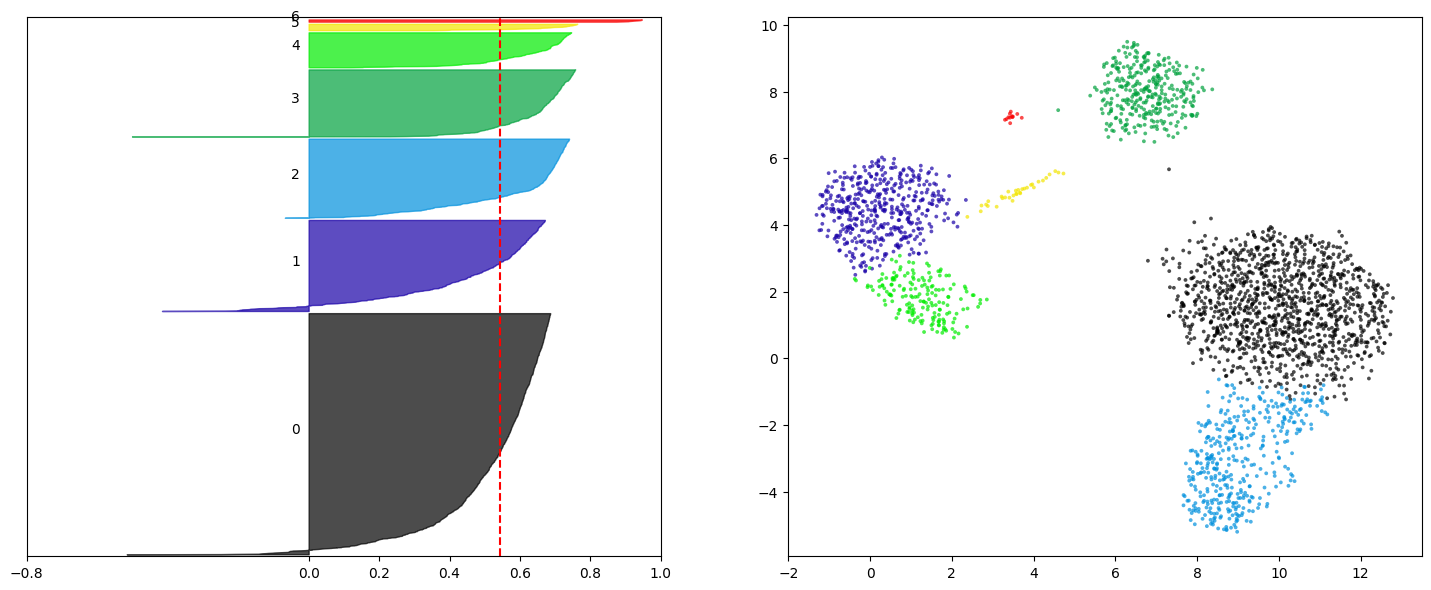

For n_clusters = 7 The average silhouette_score is: 0.54537266


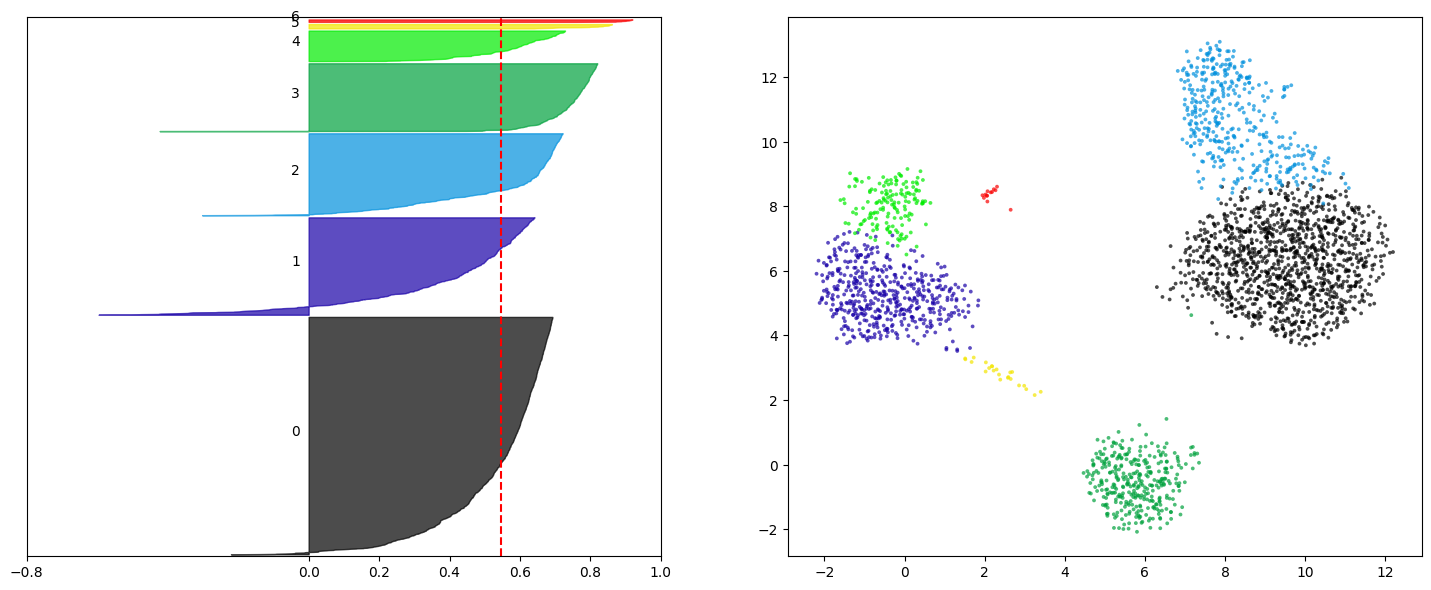

For n_clusters = 5 The average silhouette_score is: 0.5494578


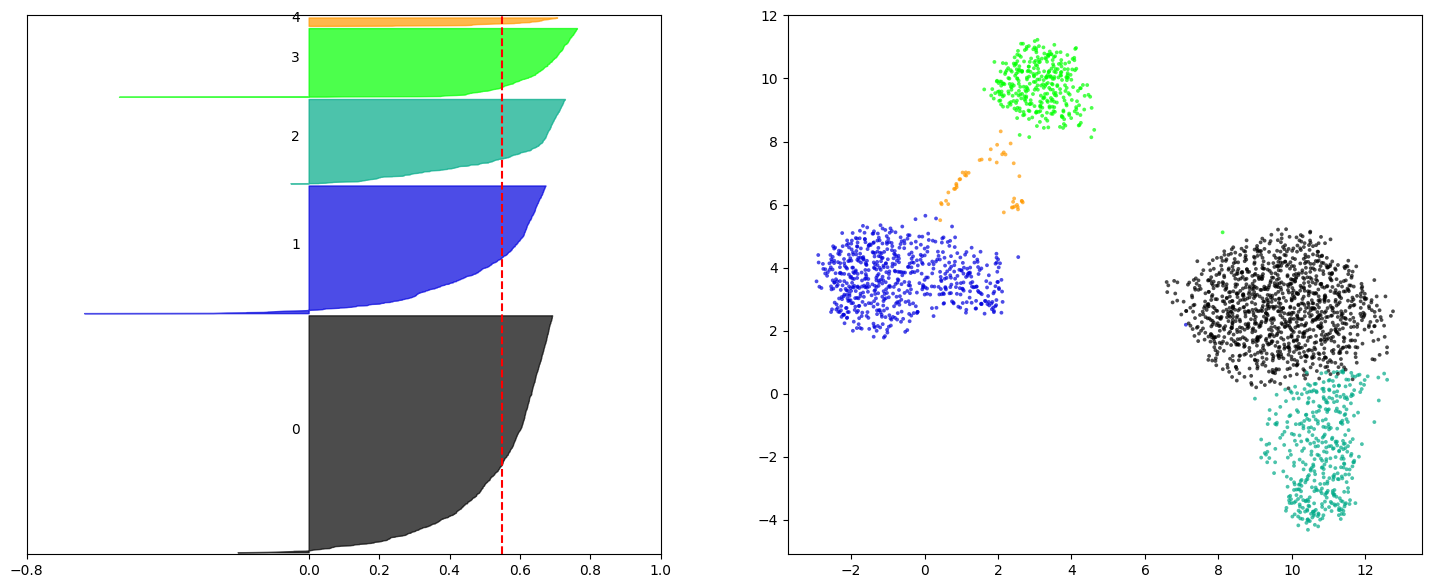

For n_clusters = 5 The average silhouette_score is: 0.556152


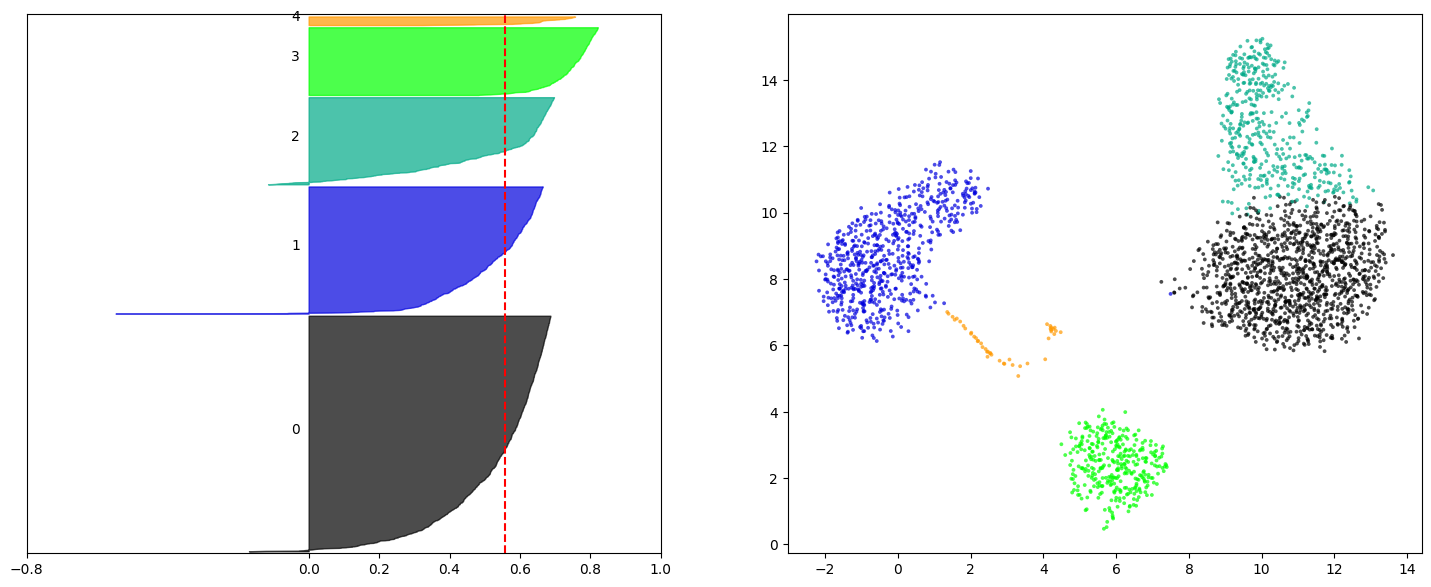

For n_clusters = 6 The average silhouette_score is: 0.5411925


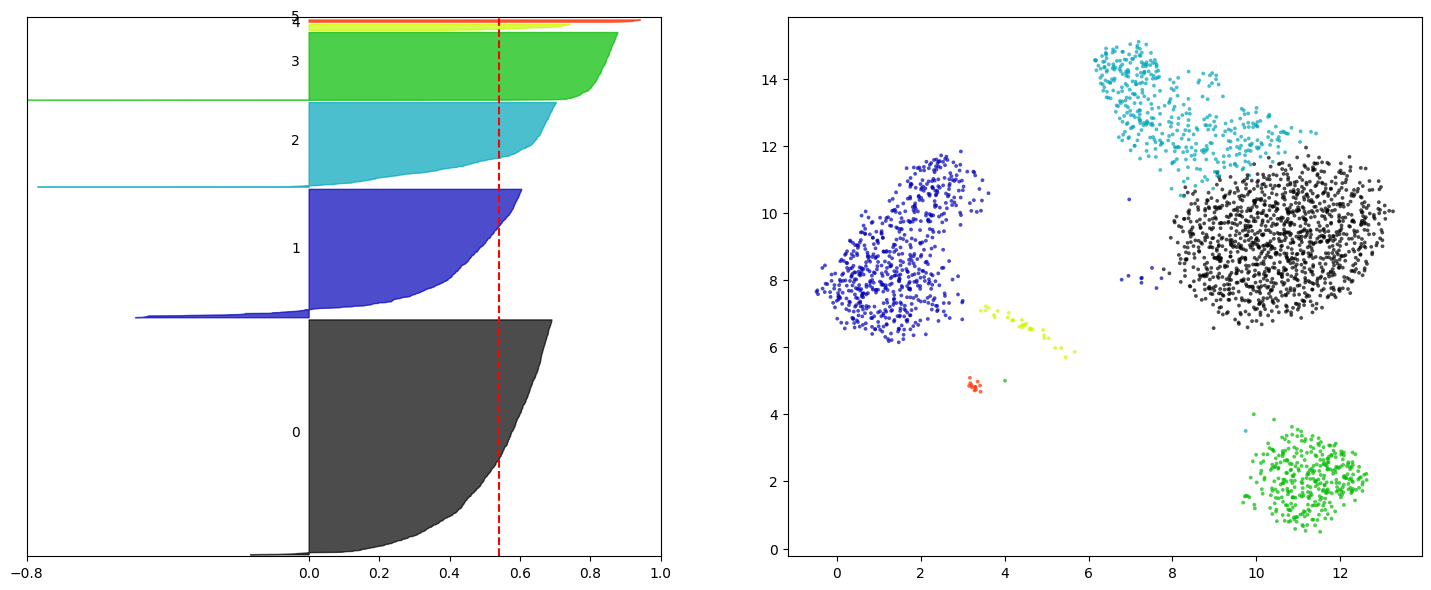

For n_clusters = 6 The average silhouette_score is: 0.52003515


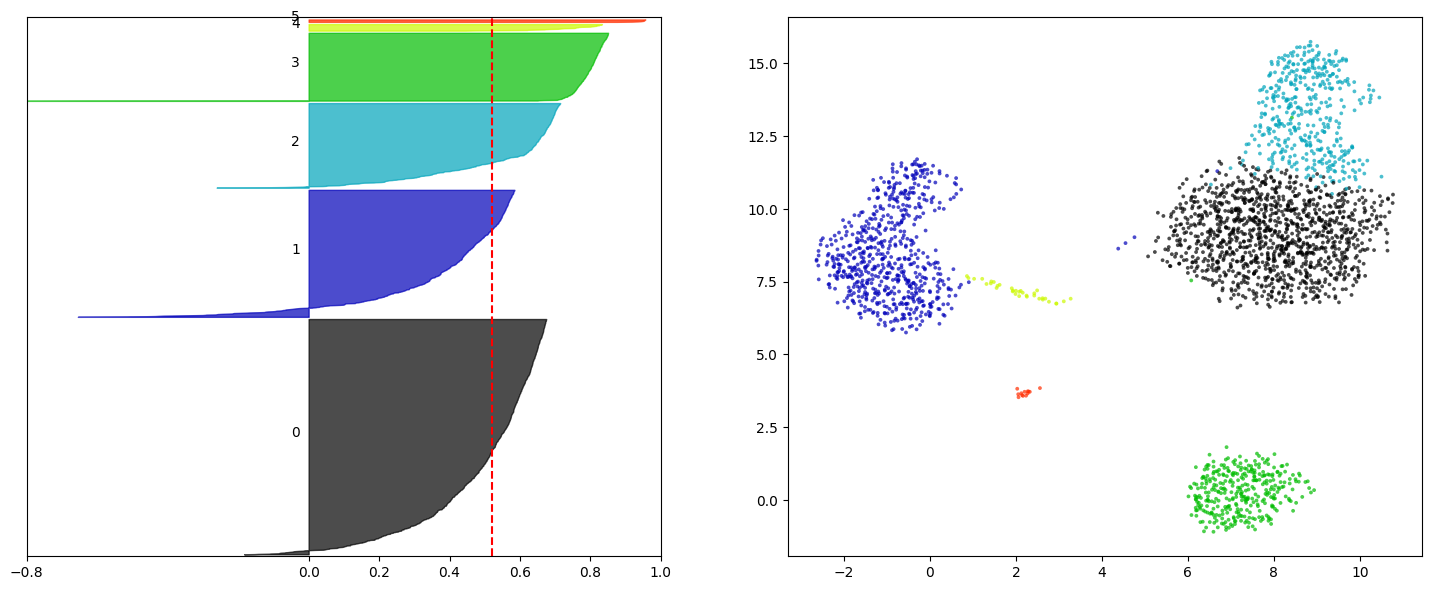

For n_clusters = 6 The average silhouette_score is: 0.6023807


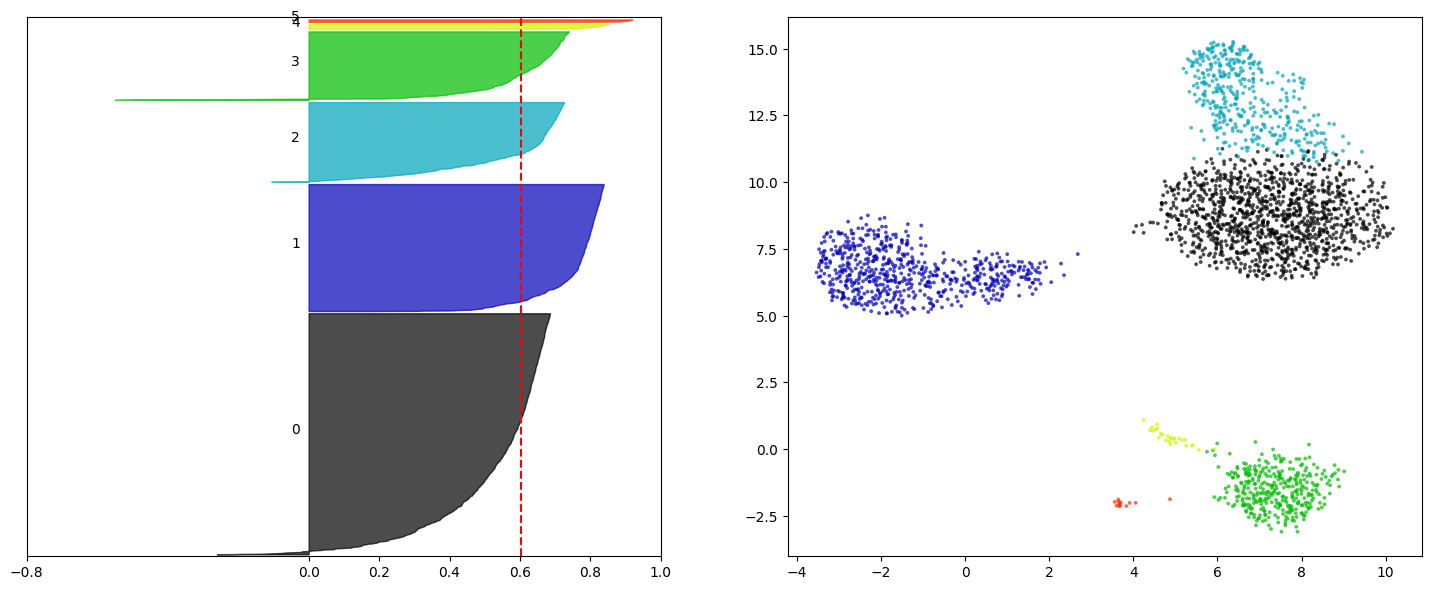

For n_clusters = 6 The average silhouette_score is: 0.50815916


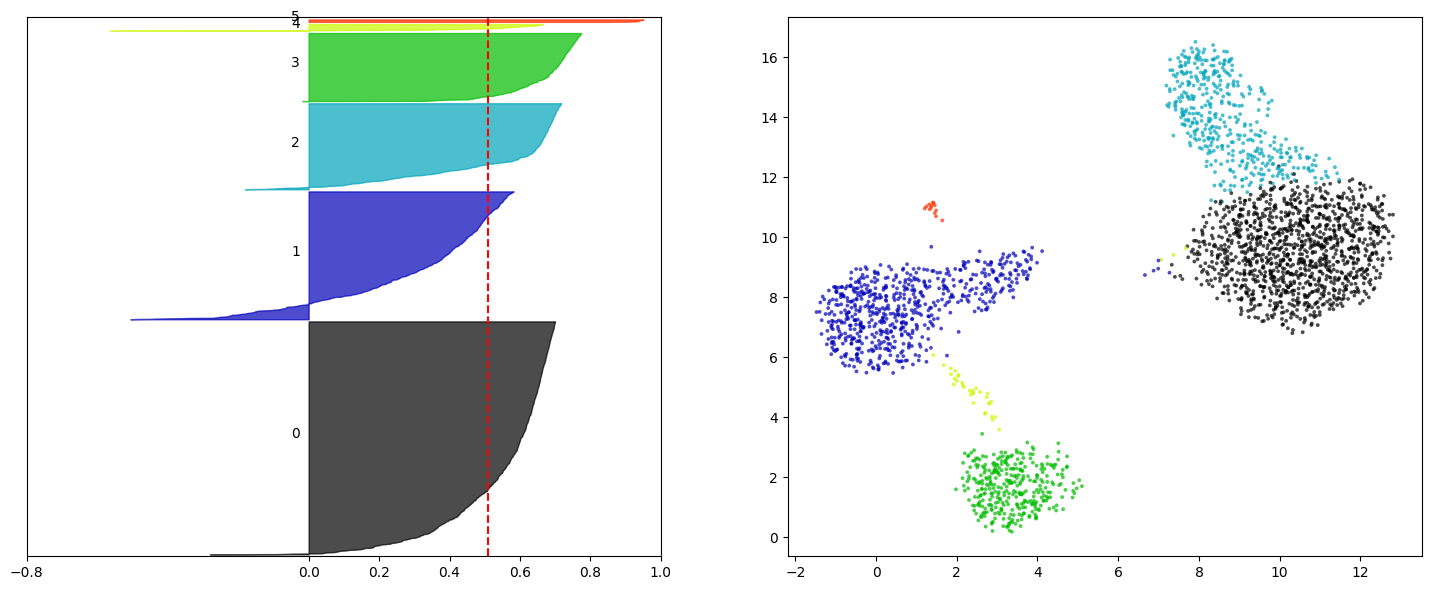

For n_clusters = 6 The average silhouette_score is: 0.5522154


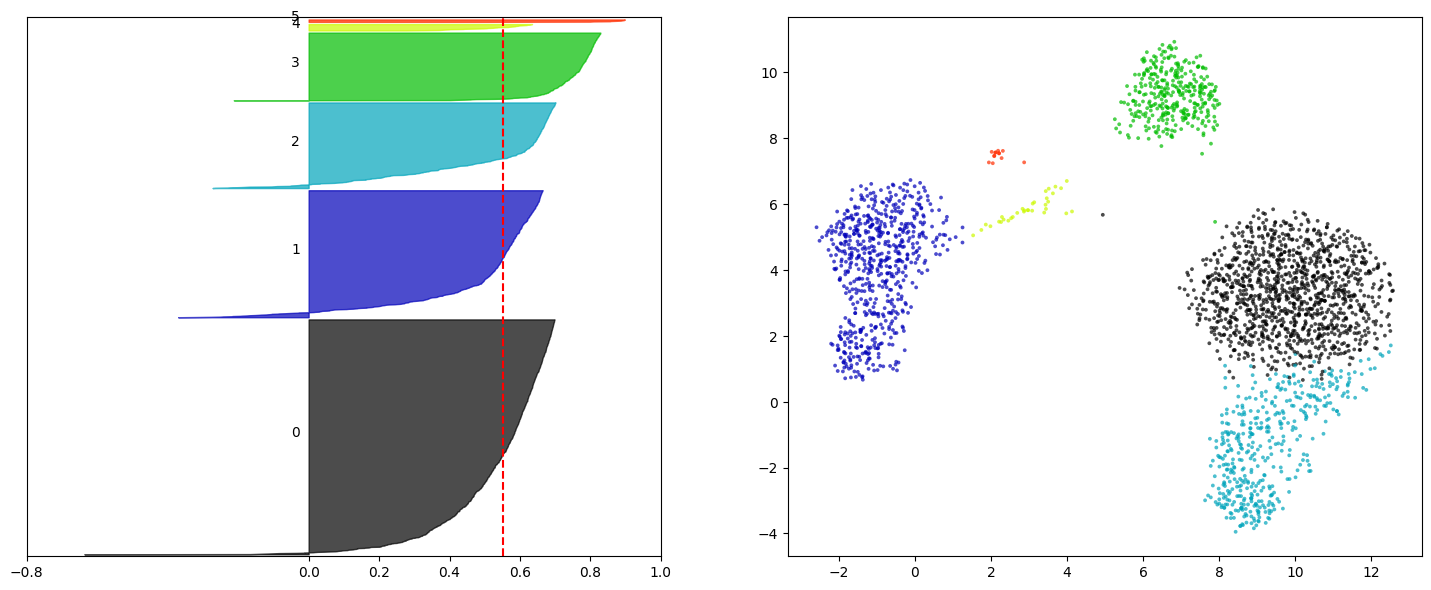

For n_clusters = 6 The average silhouette_score is: 0.54647


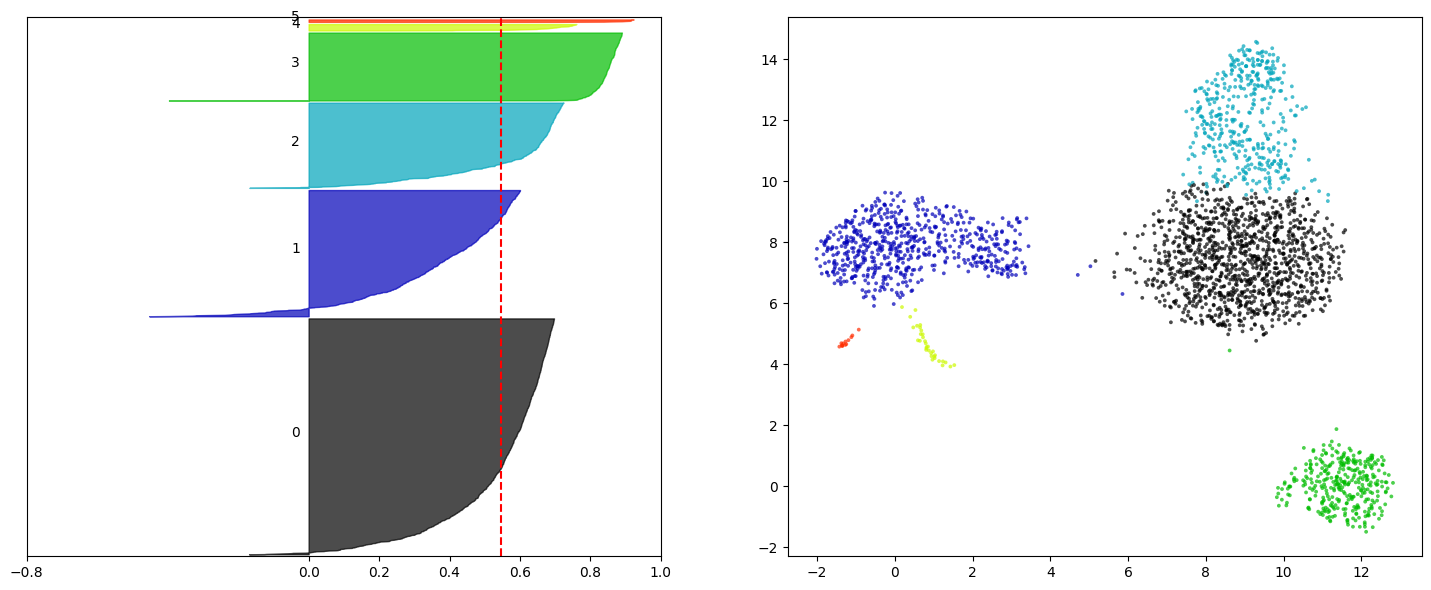

For n_clusters = 6 The average silhouette_score is: 0.5401701


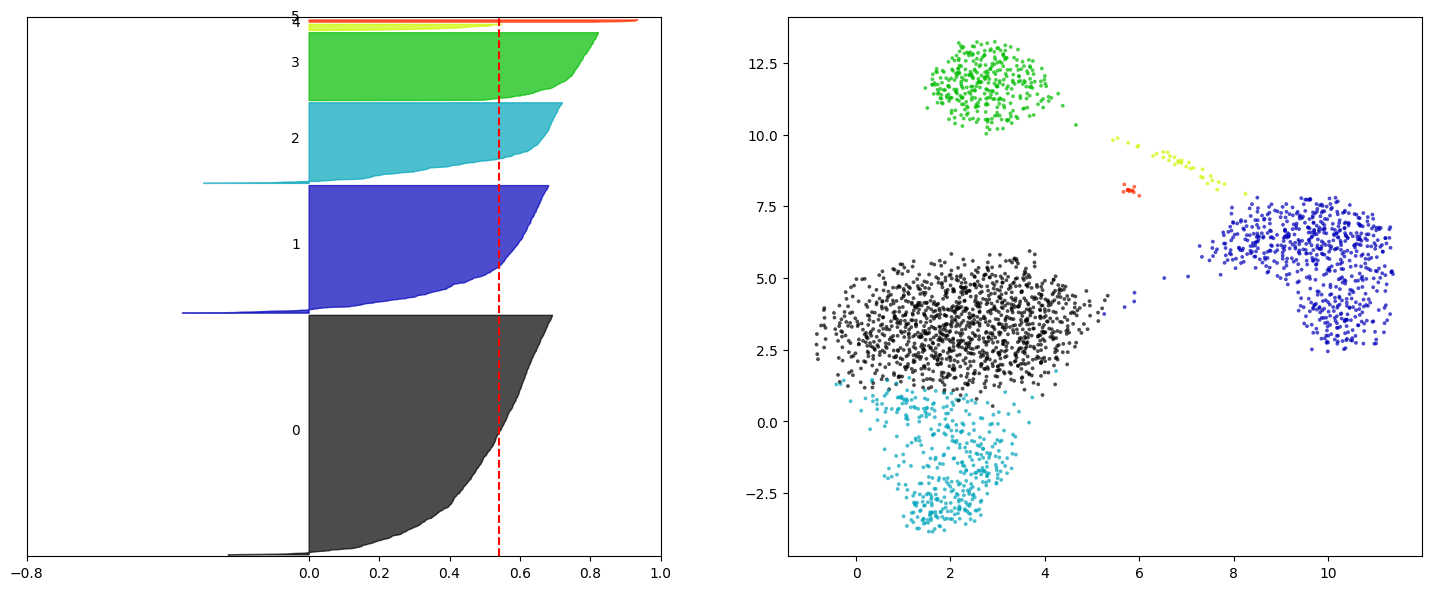

For n_clusters = 6 The average silhouette_score is: 0.5405952


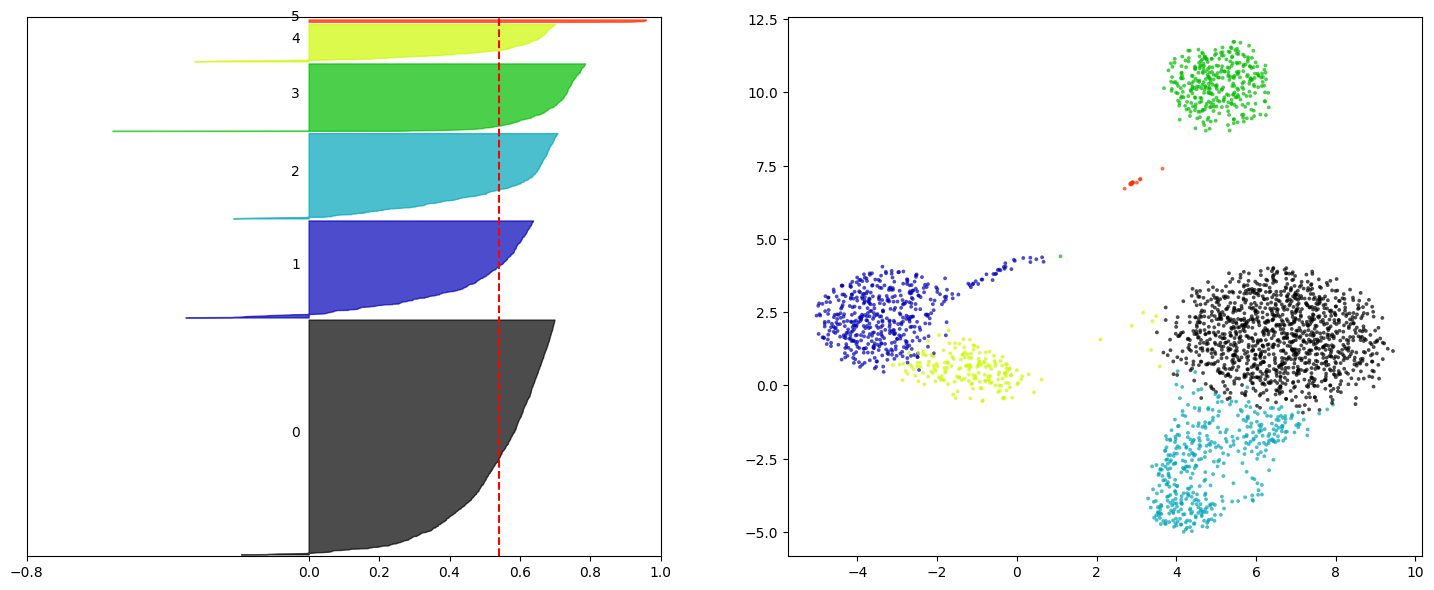

For n_clusters = 7 The average silhouette_score is: 0.528514


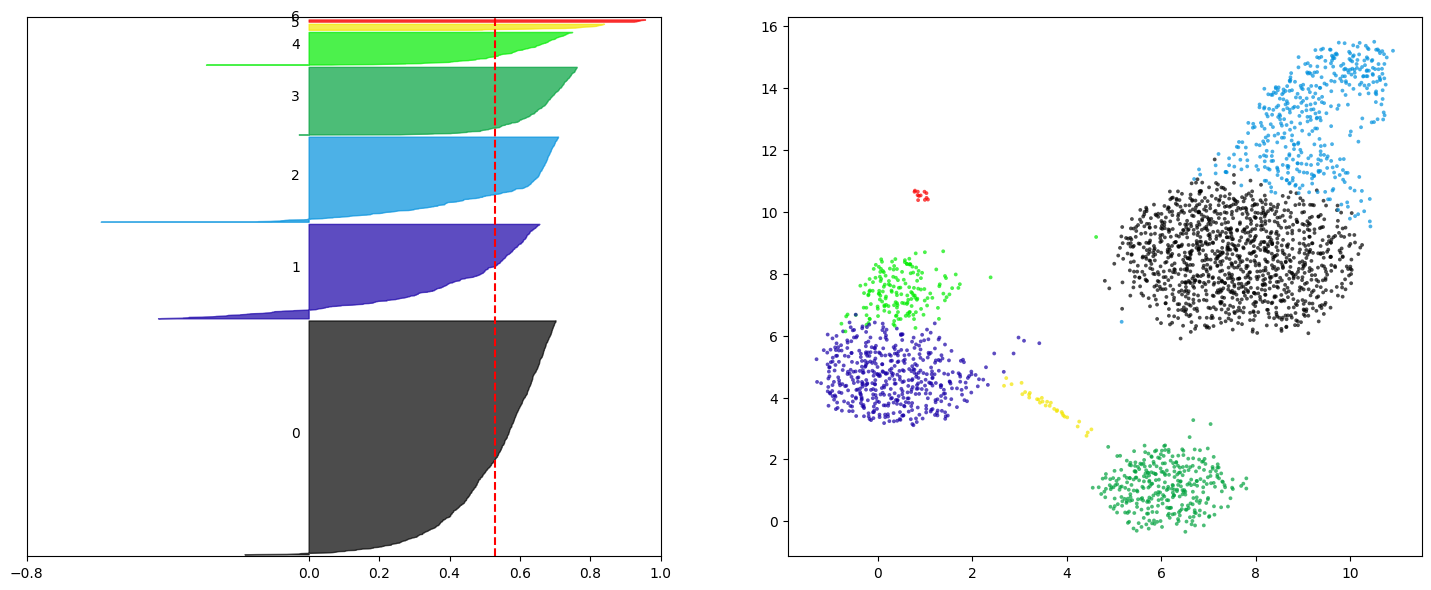

For n_clusters = 6 The average silhouette_score is: 0.52550966


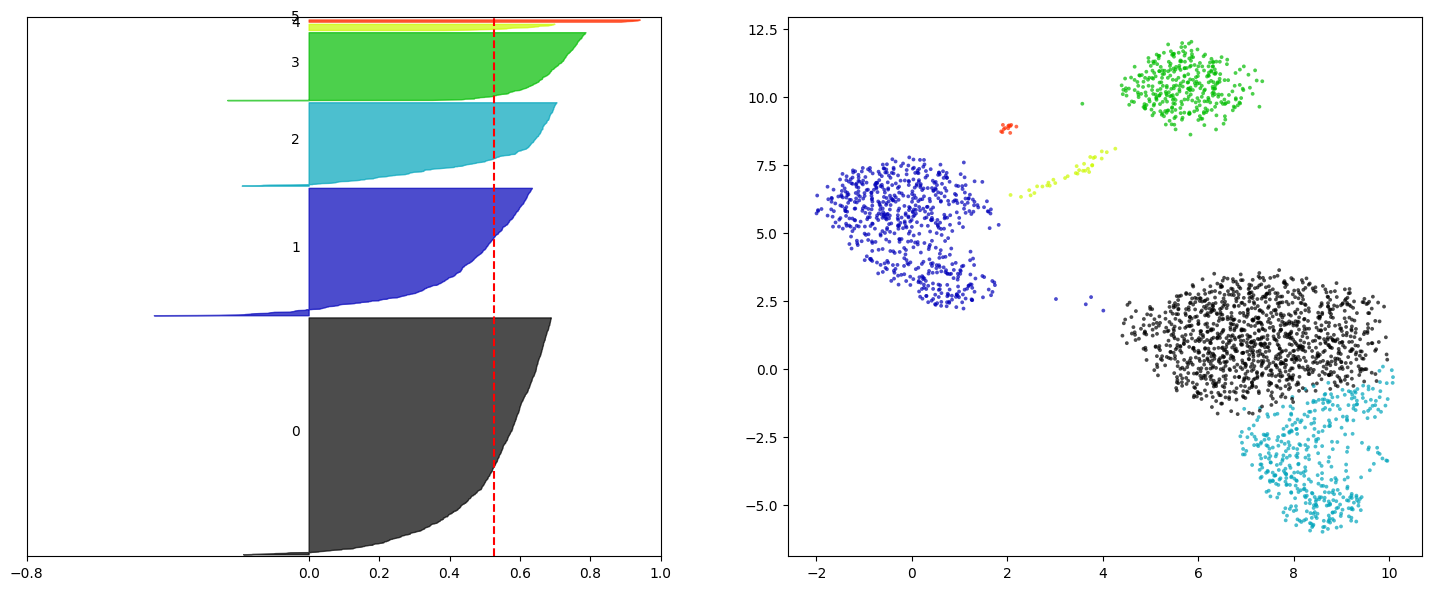

For n_clusters = 5 The average silhouette_score is: 0.5529549


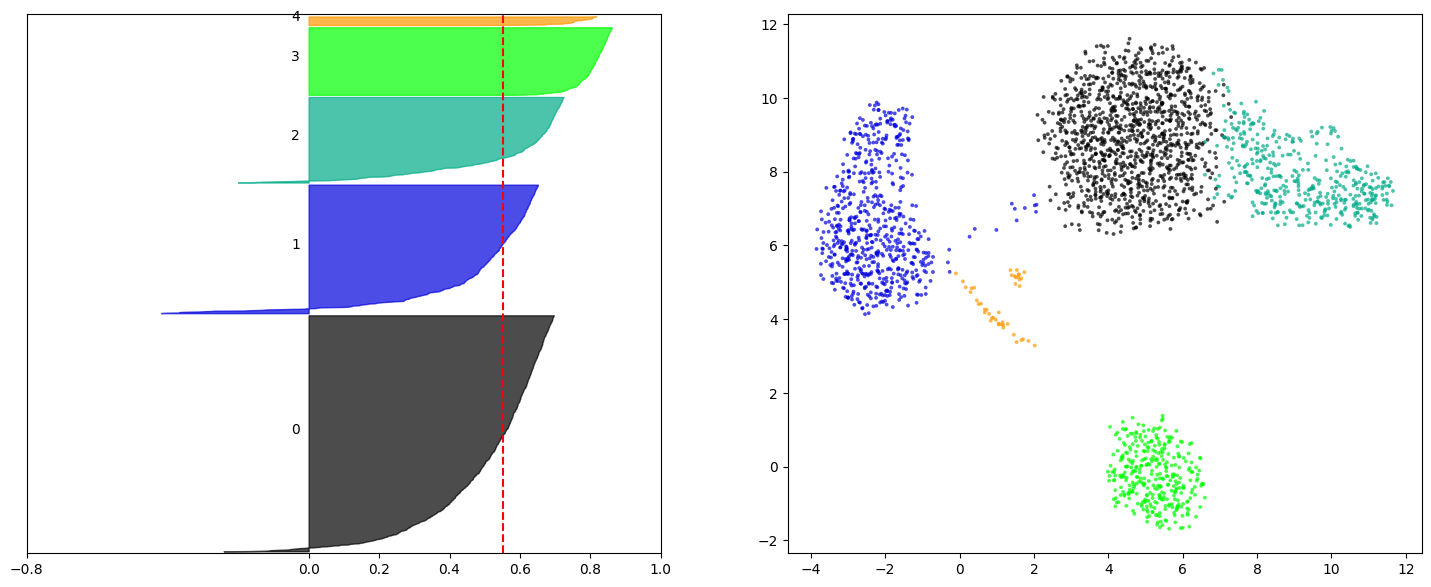

For n_clusters = 6 The average silhouette_score is: 0.53790516


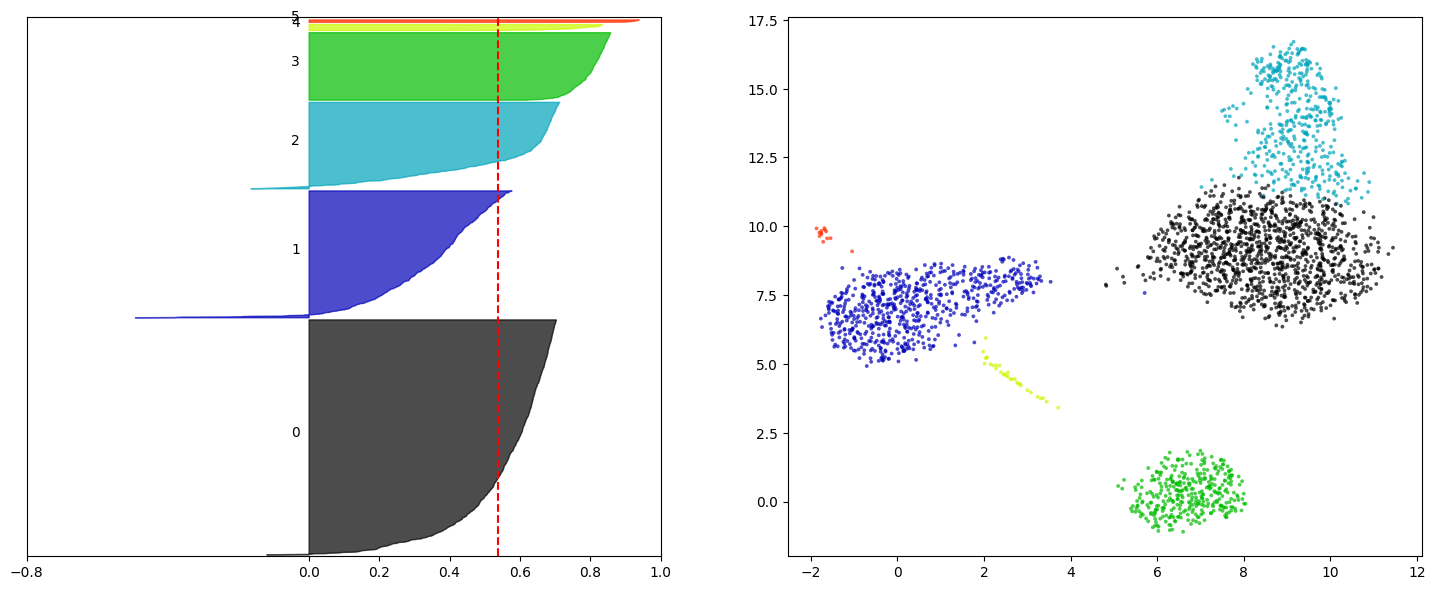

For n_clusters = 6 The average silhouette_score is: 0.5360657


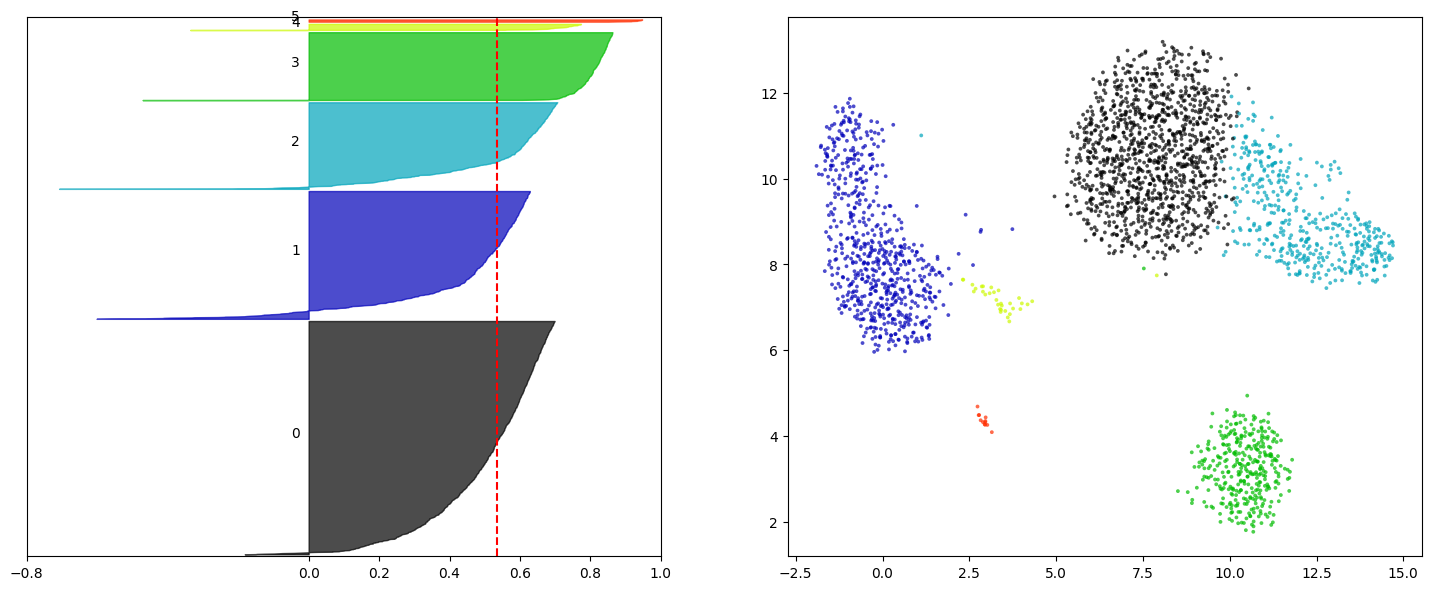

For n_clusters = 6 The average silhouette_score is: 0.5209533


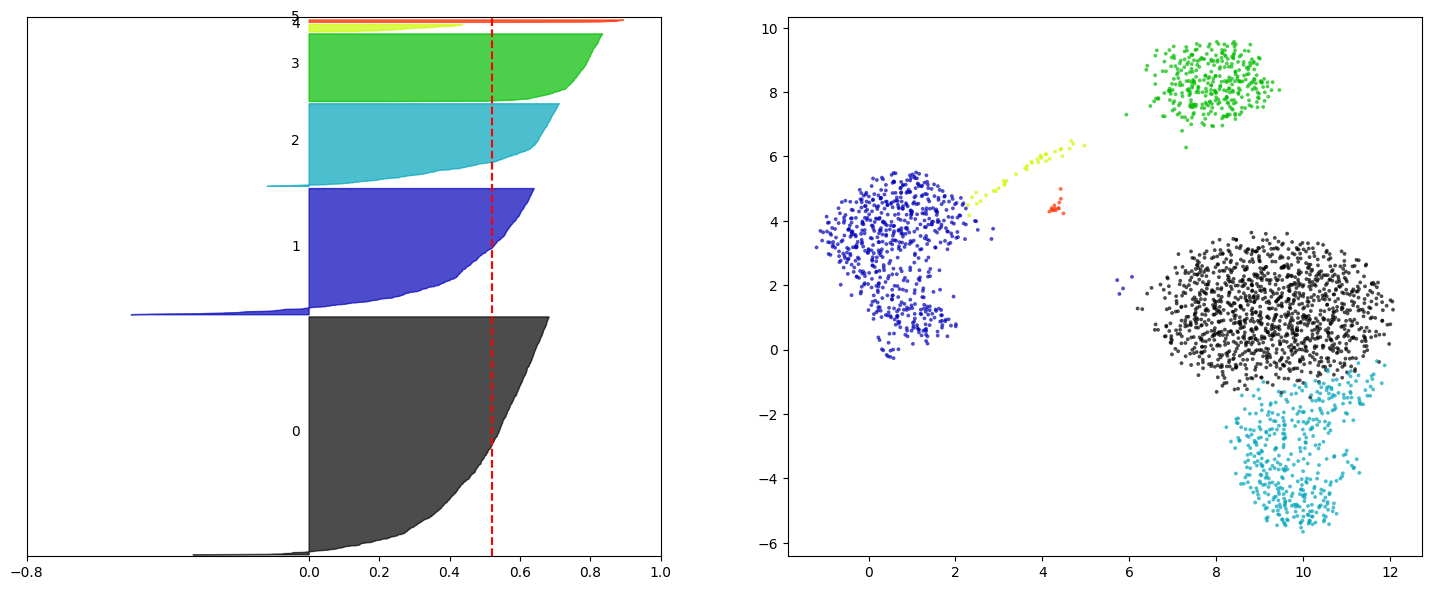

For n_clusters = 6 The average silhouette_score is: 0.5247464


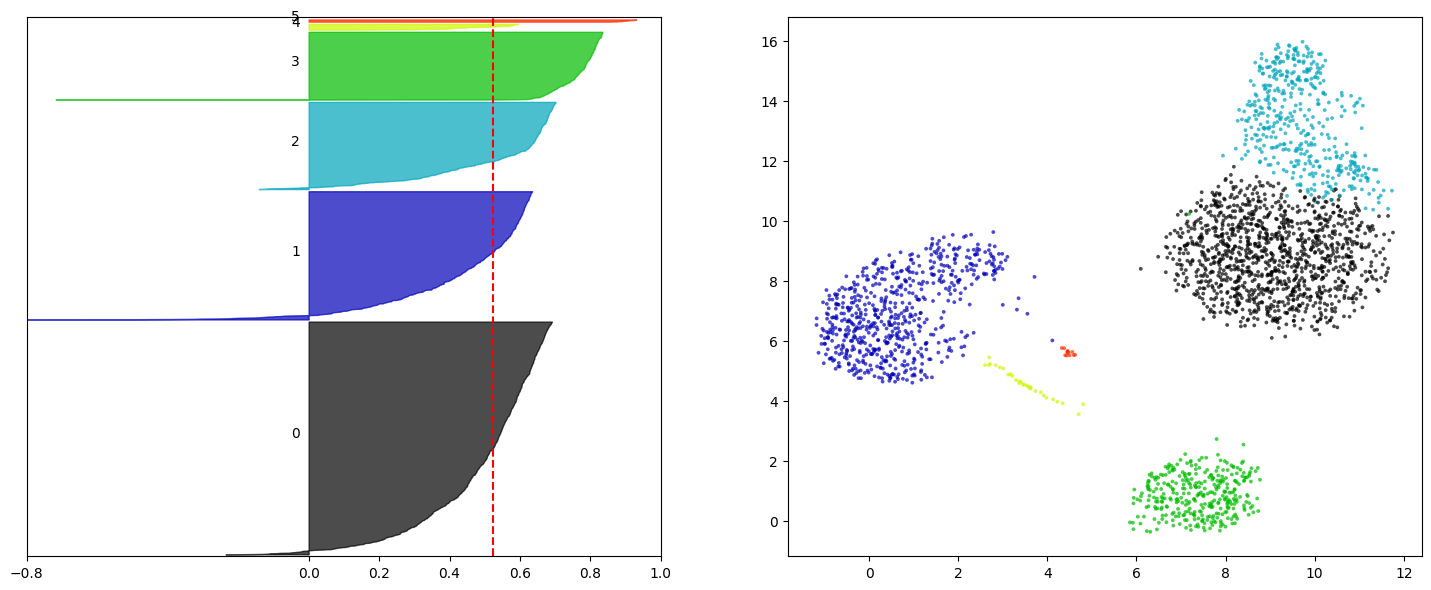

For n_clusters = 6 The average silhouette_score is: 0.5203089


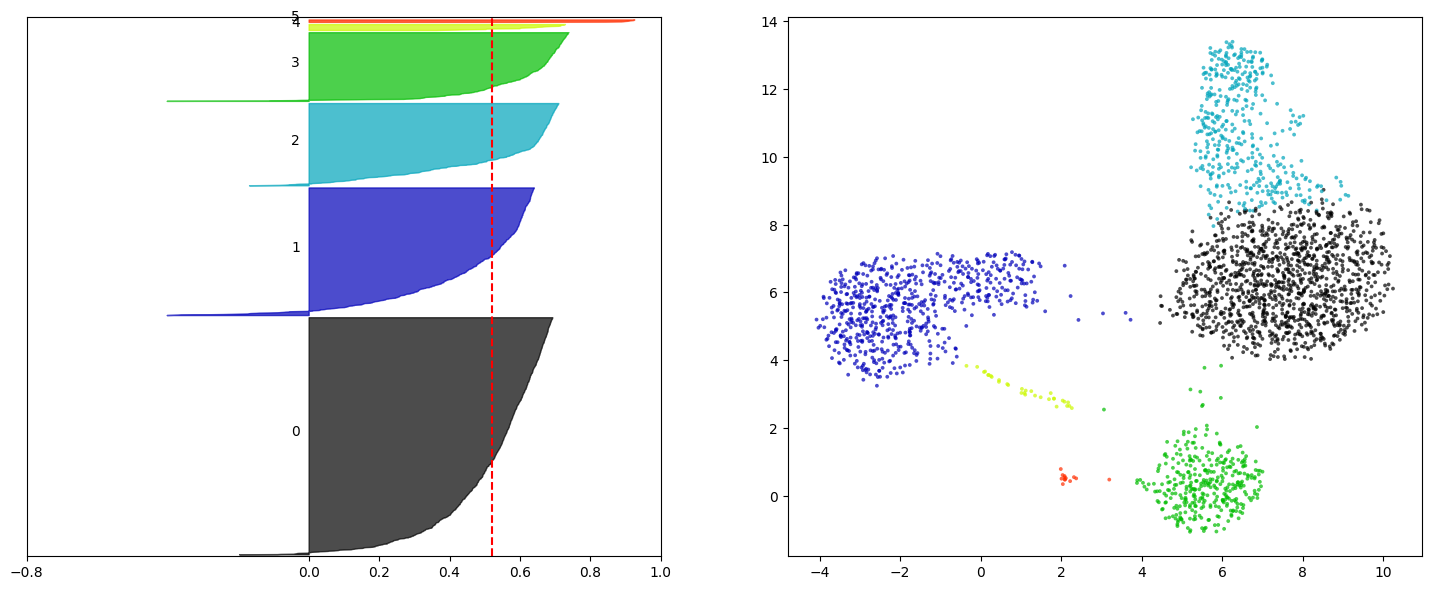

In [344]:
for seed in np.arange(0,20,1):
    
    torch.manual_seed(seed)
    
    FILE_VAE = f"model_VAE_seed{seed}.pth"
    FILE_AE  = f"model_AE_seed{seed}.pth"
    
    loaded_model_AE, loaded_model_VAE = ModelsNN(adata.X.shape[1],1024,40)
    
    loaded_model_AE.to(device)
    loaded_model_VAE.to(device)
    
    loaded_model_AE.load_state_dict(torch.load(FILE_AE, map_location=device))
    loaded_model_VAE.load_state_dict(torch.load(FILE_VAE, map_location=device))
    
    loaded_model_AE.eval()
    loaded_model_VAE.eval()
    
    adata_latent,_ = loaded_model_AE(adata_tensor)
    adata_latent_np = adata_latent.cpu().detach().numpy()
    adata.obsm["X_AE"] = adata_latent_np

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_AE")
    sc.tl.leiden(adata,resolution=0.6,)
    sc.tl.umap(adata)

    X = adata.obsm["X_umap"]
    cluster_labels = adata.obs["leiden"]
    if True: ### adapeded from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is:",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )


        plt.show()

For n_clusters = 8 The average silhouette_score is: 0.499933


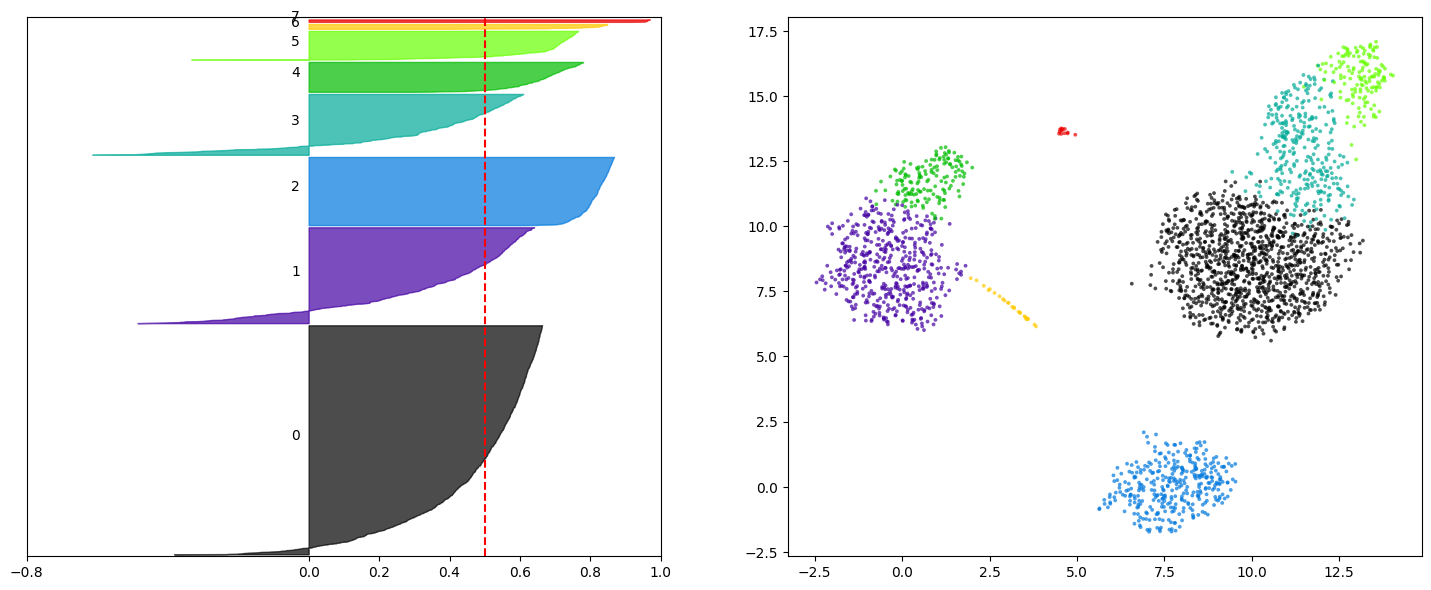

For n_clusters = 7 The average silhouette_score is: 0.54254365


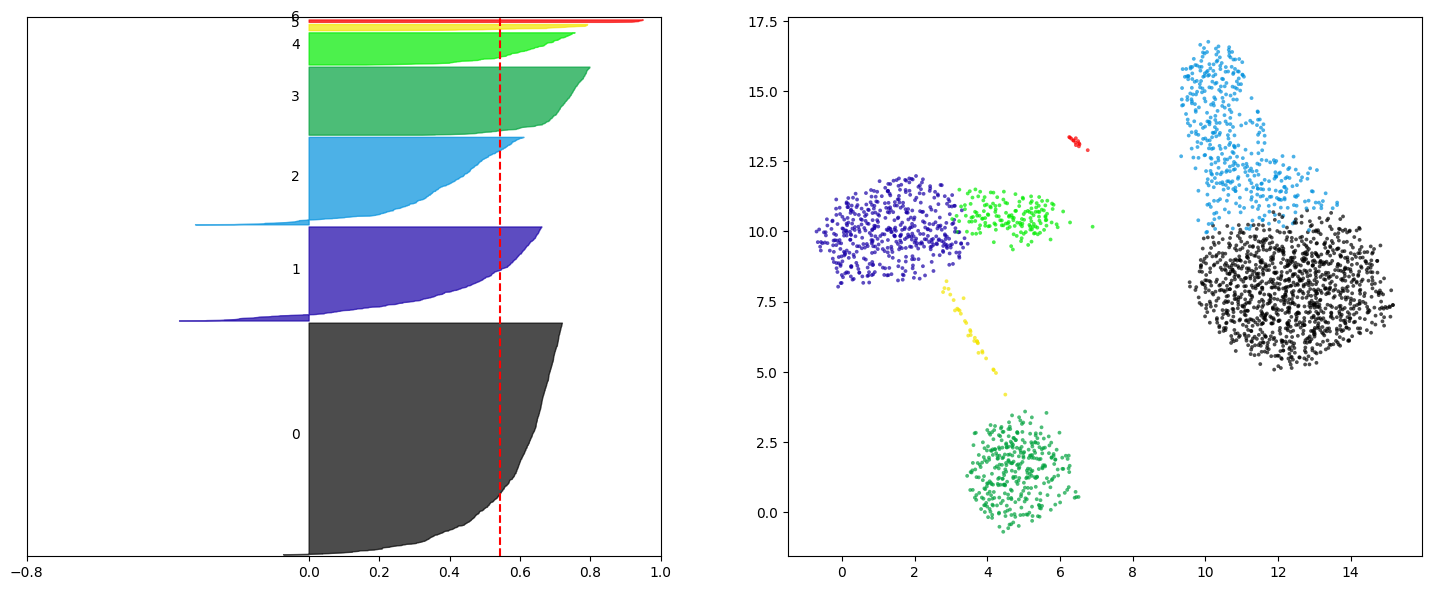

For n_clusters = 8 The average silhouette_score is: 0.4972083


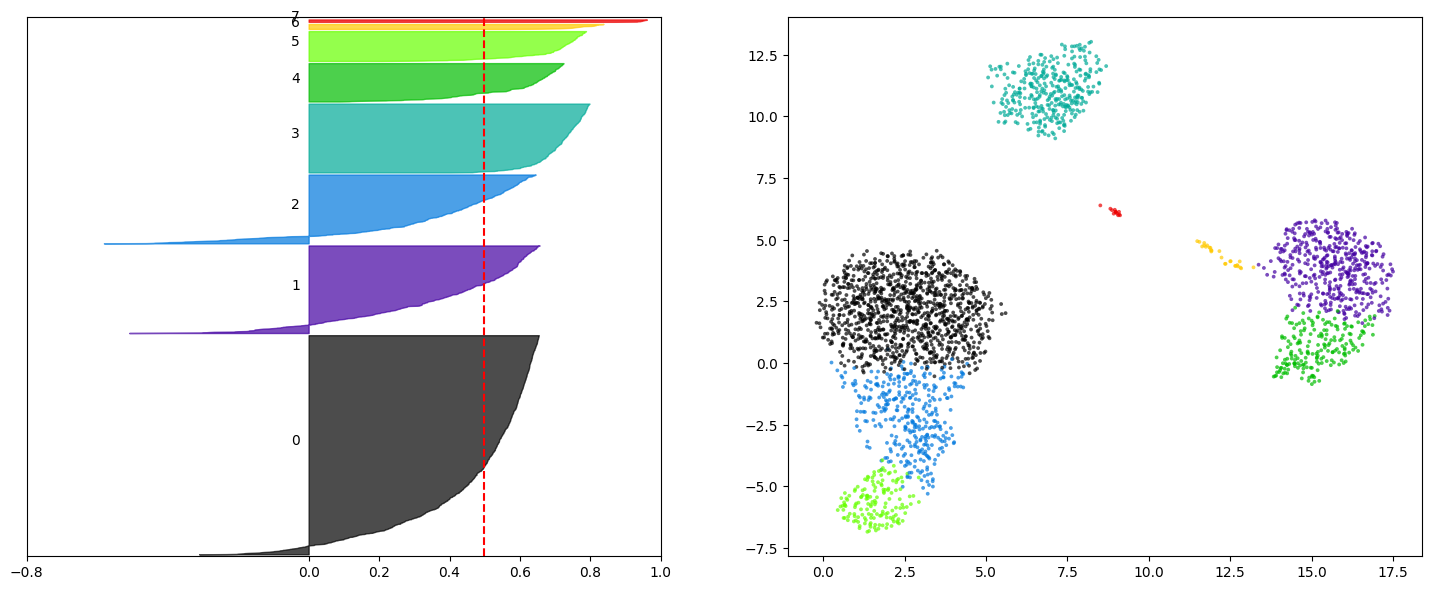

For n_clusters = 6 The average silhouette_score is: 0.49912727


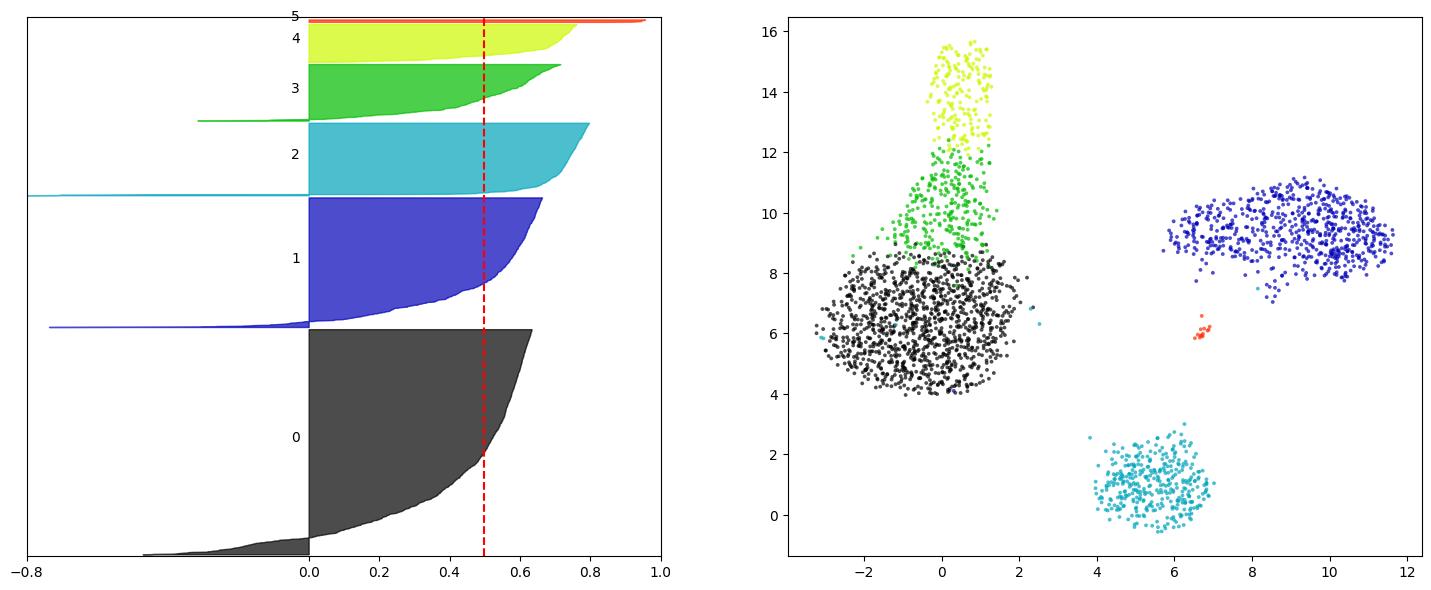

For n_clusters = 7 The average silhouette_score is: 0.5188013


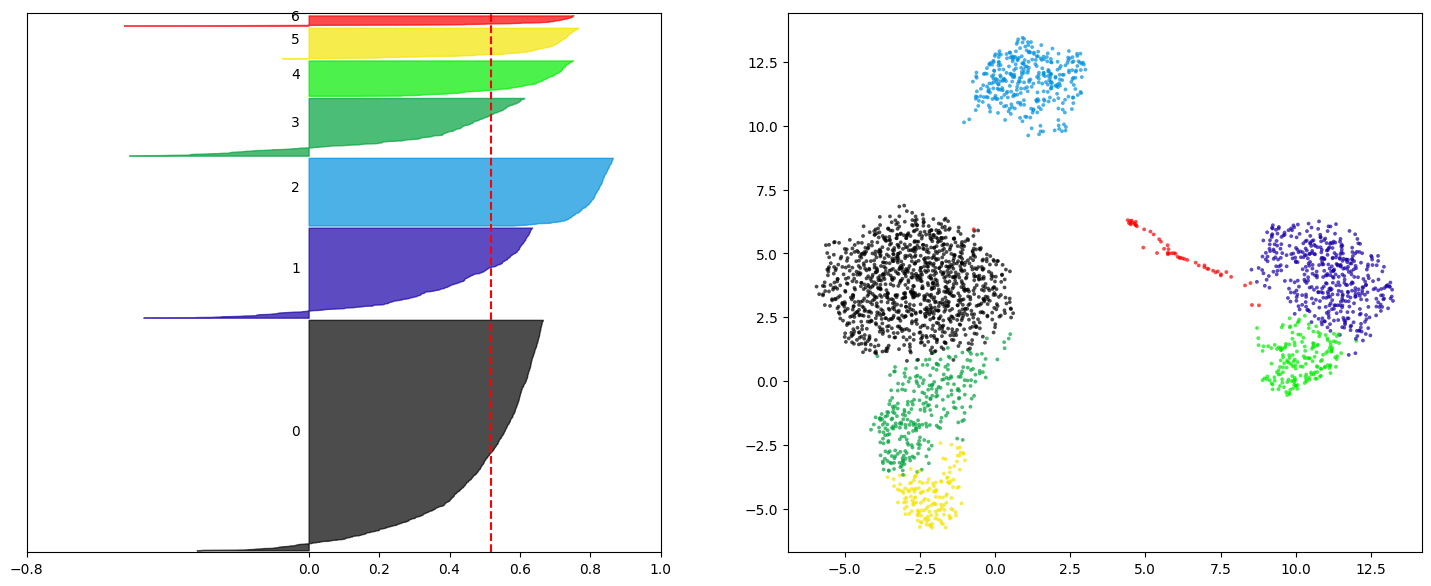

For n_clusters = 6 The average silhouette_score is: 0.5104056


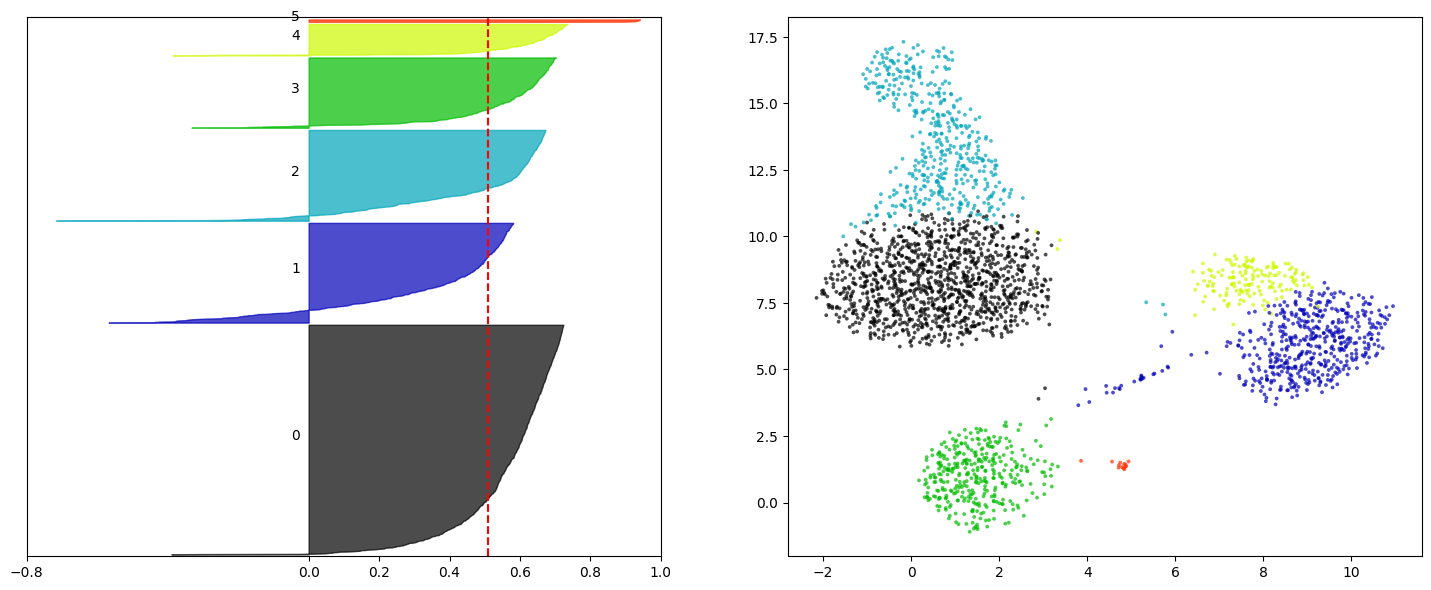

For n_clusters = 5 The average silhouette_score is: 0.6285784


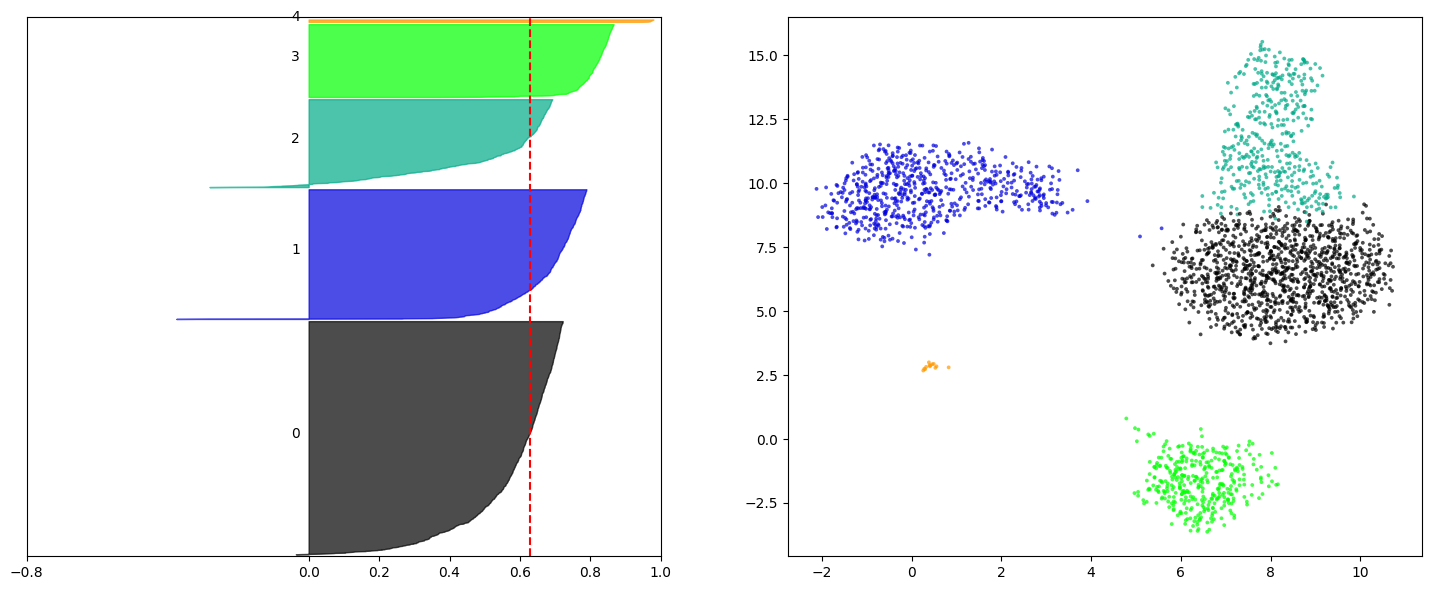

For n_clusters = 6 The average silhouette_score is: 0.5455917


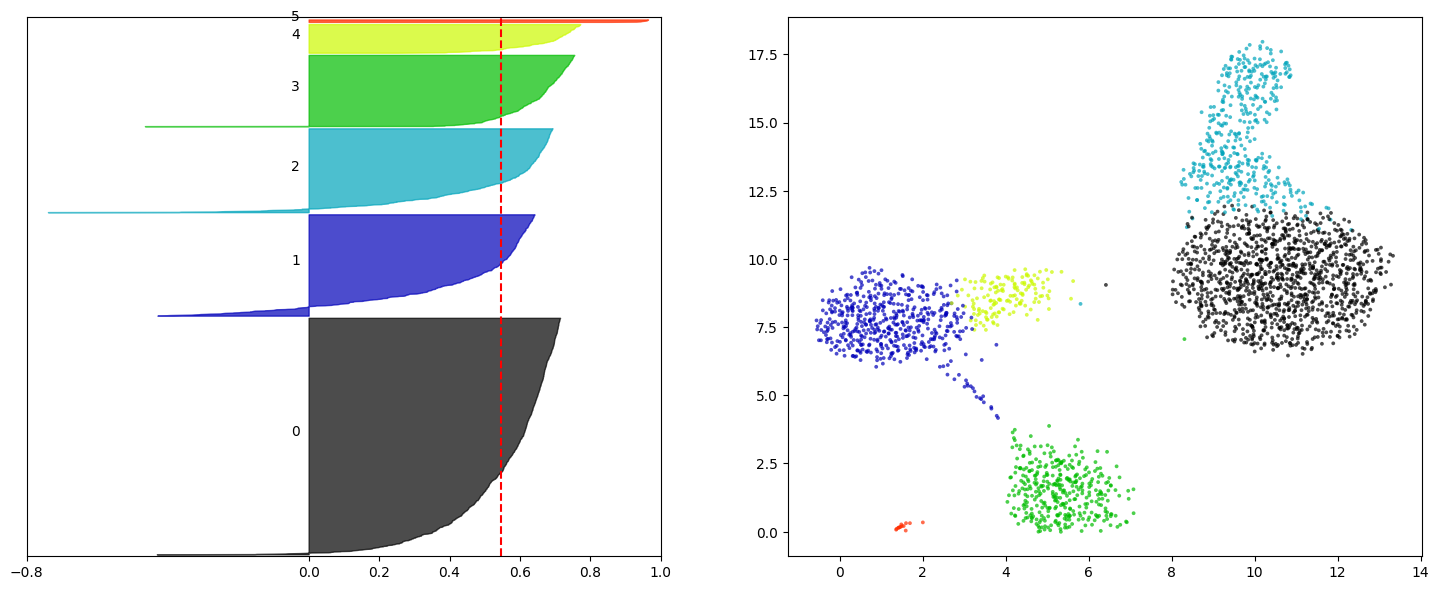

For n_clusters = 8 The average silhouette_score is: 0.4987693


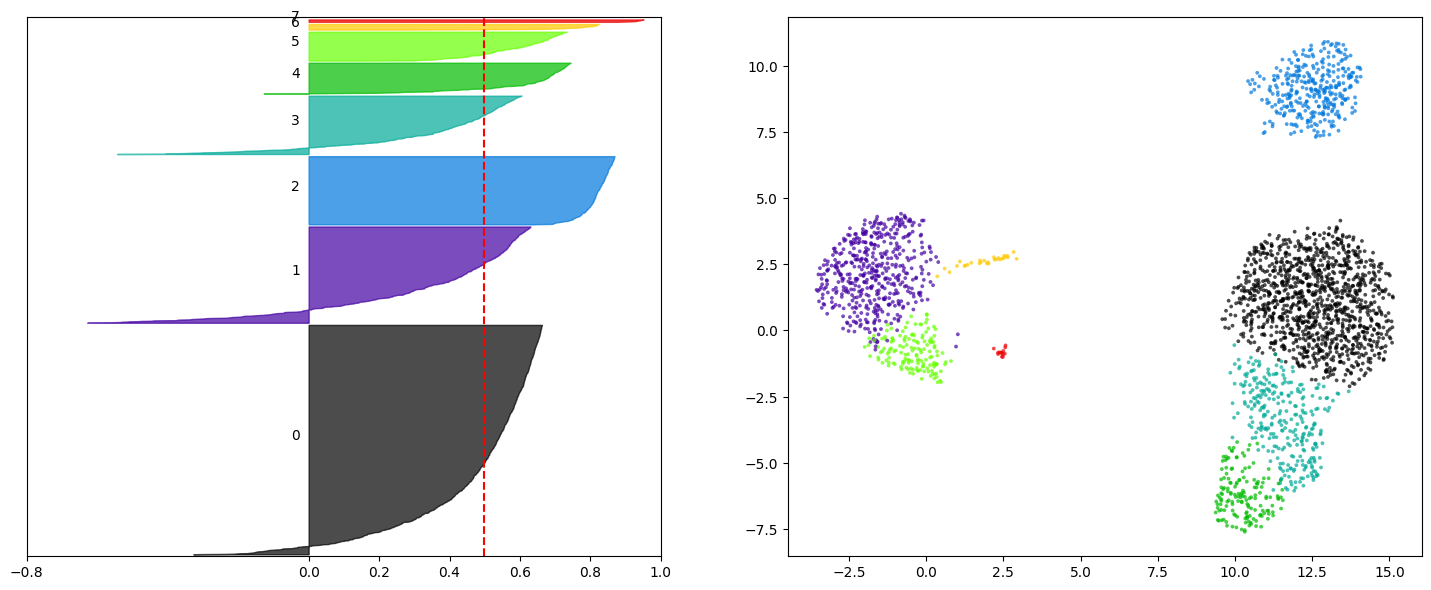

For n_clusters = 7 The average silhouette_score is: 0.4857968


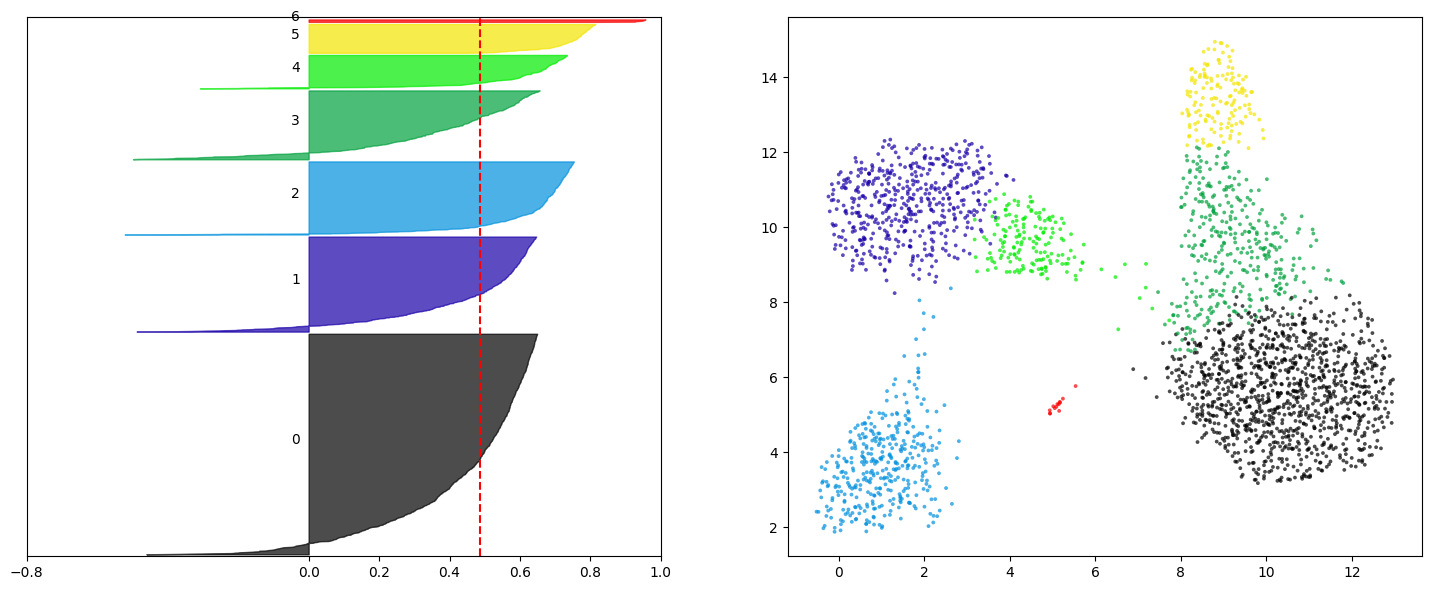

For n_clusters = 7 The average silhouette_score is: 0.48830318


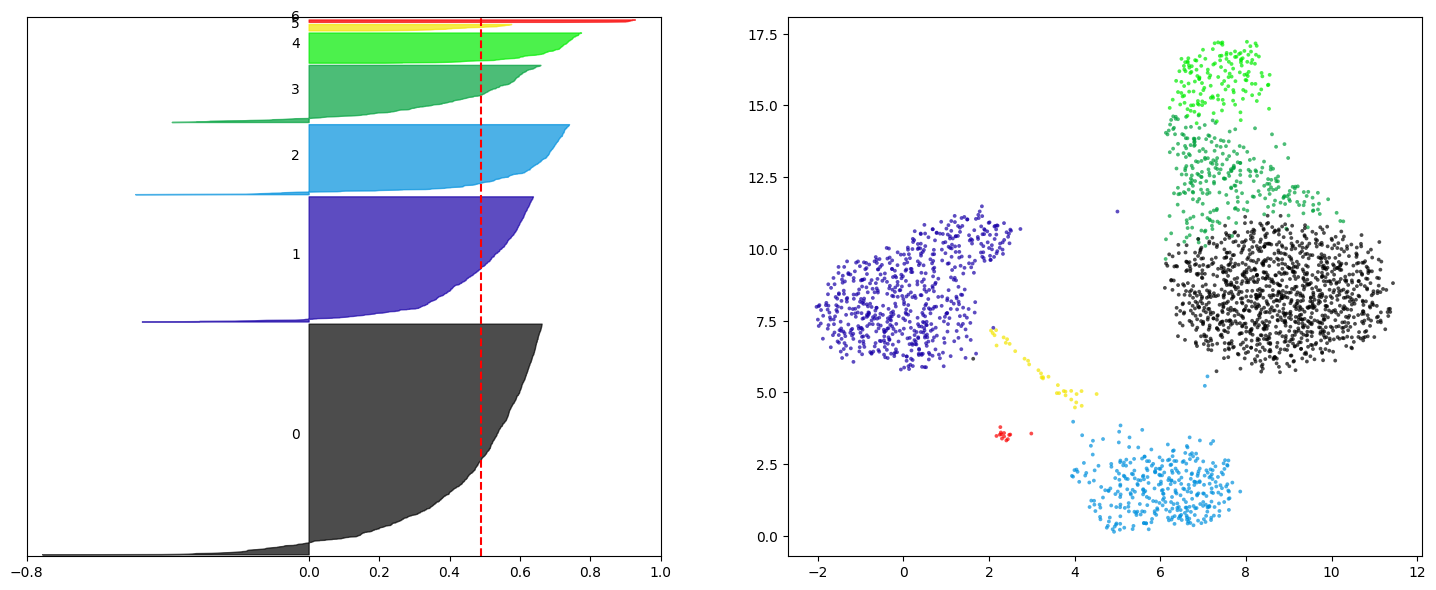

For n_clusters = 6 The average silhouette_score is: 0.552726


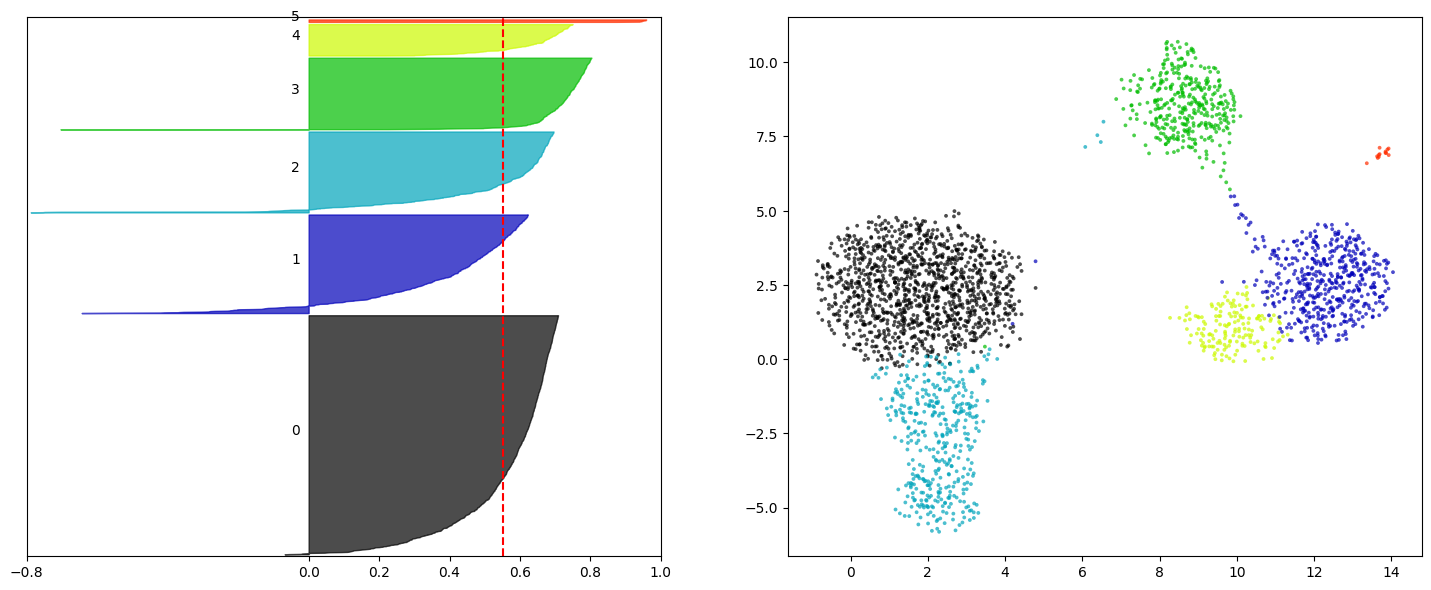

For n_clusters = 5 The average silhouette_score is: 0.610524


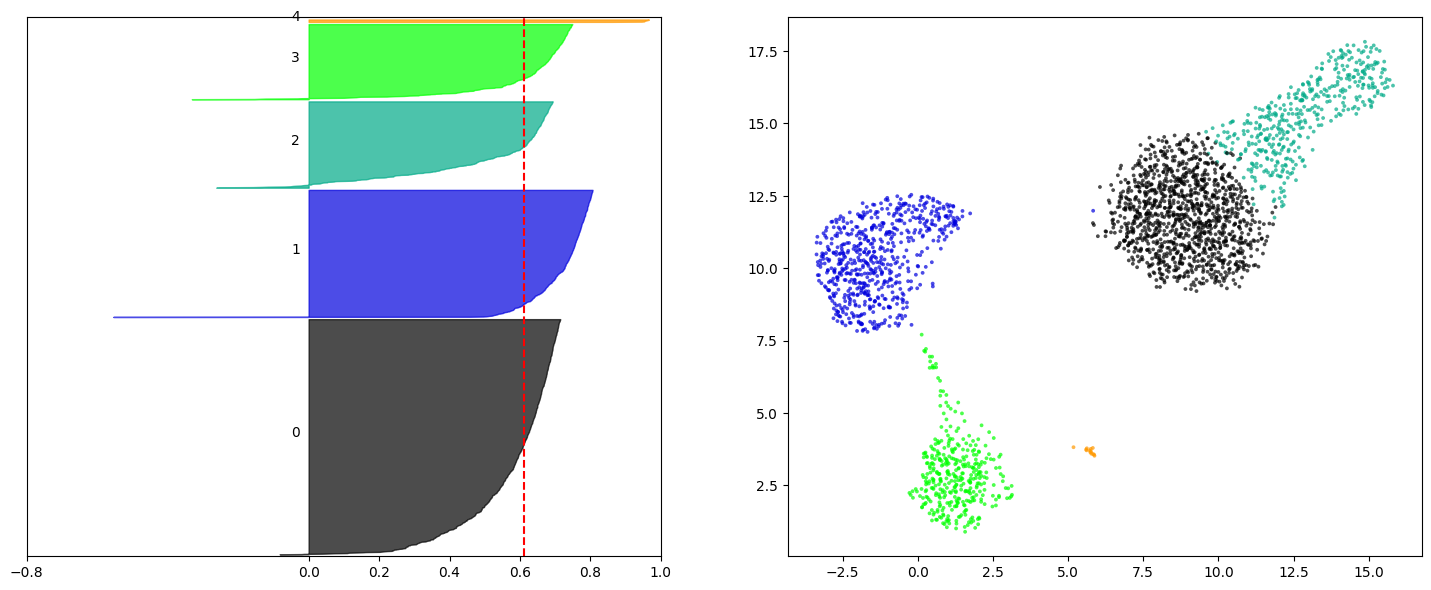

For n_clusters = 6 The average silhouette_score is: 0.58712214


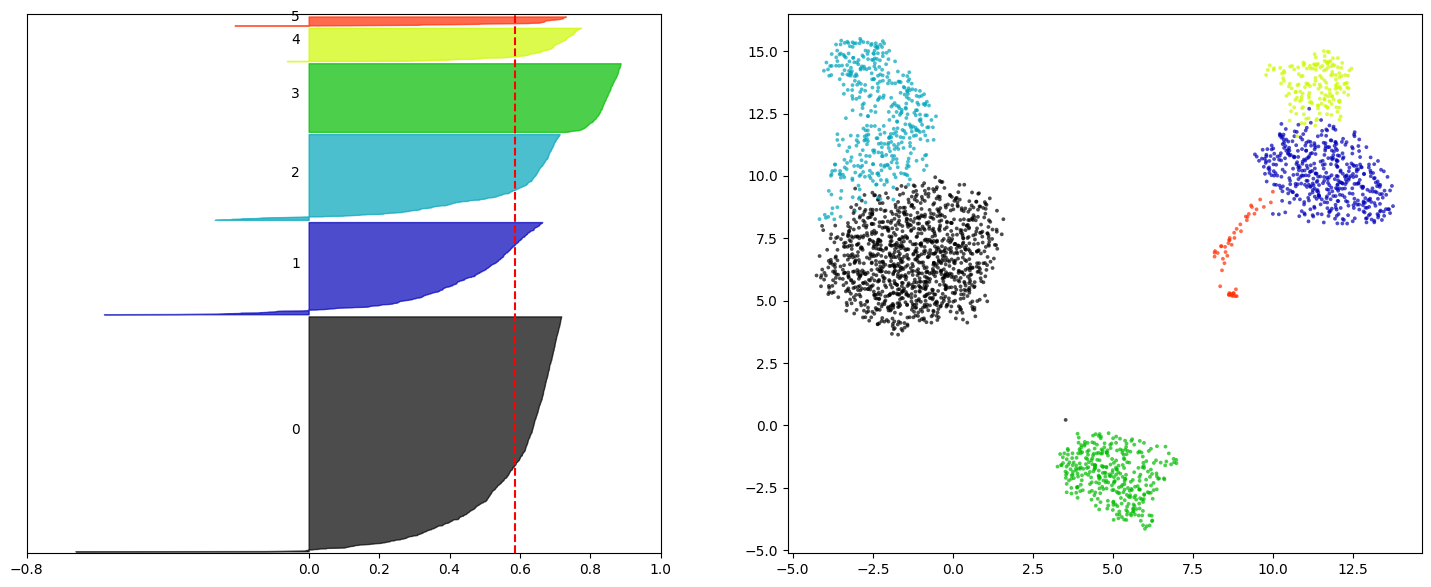

For n_clusters = 5 The average silhouette_score is: 0.60154593


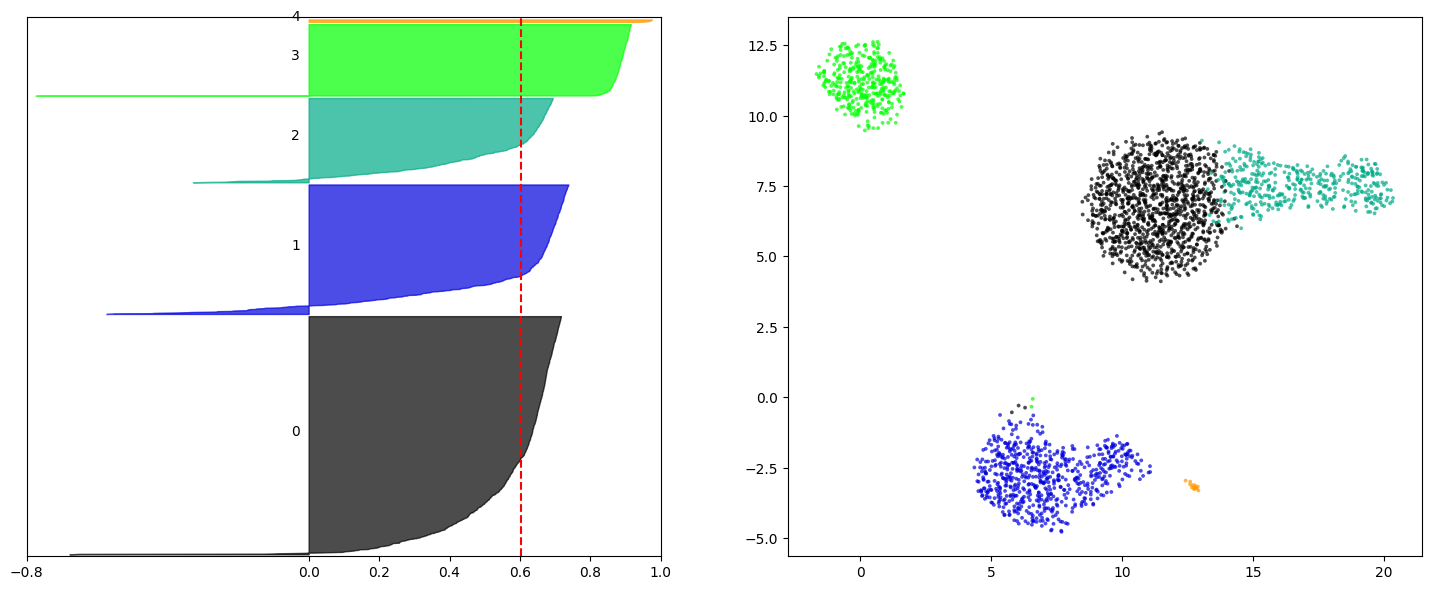

For n_clusters = 7 The average silhouette_score is: 0.49367177


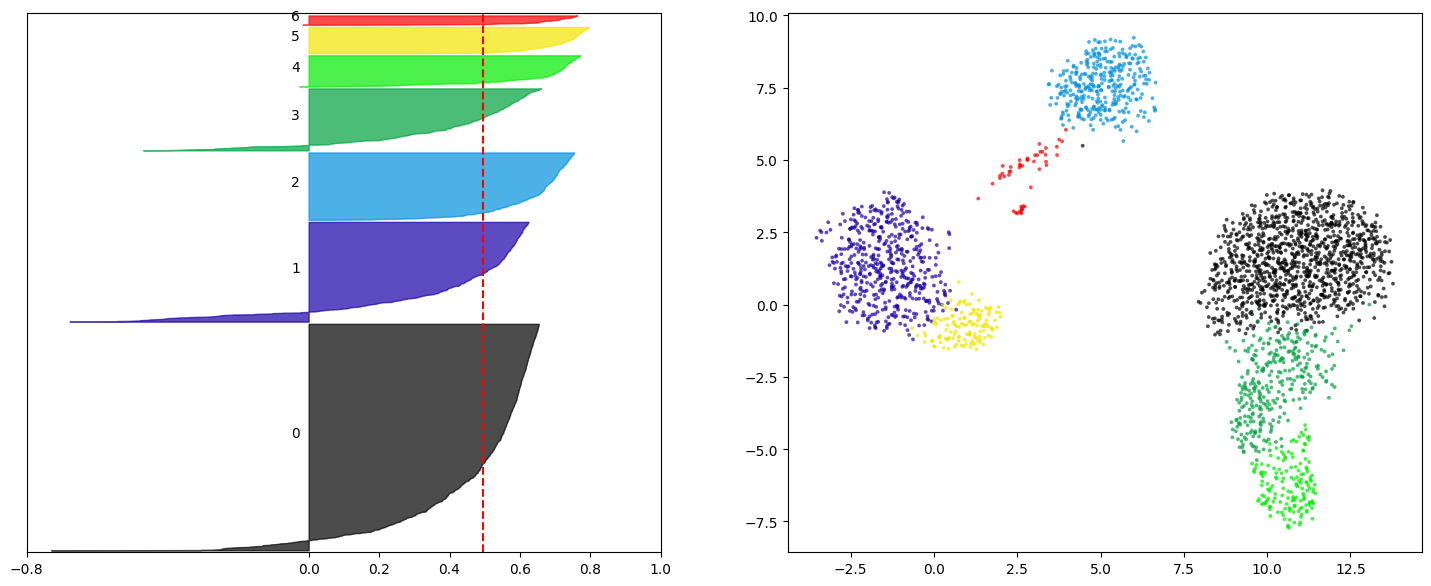

For n_clusters = 7 The average silhouette_score is: 0.5371019


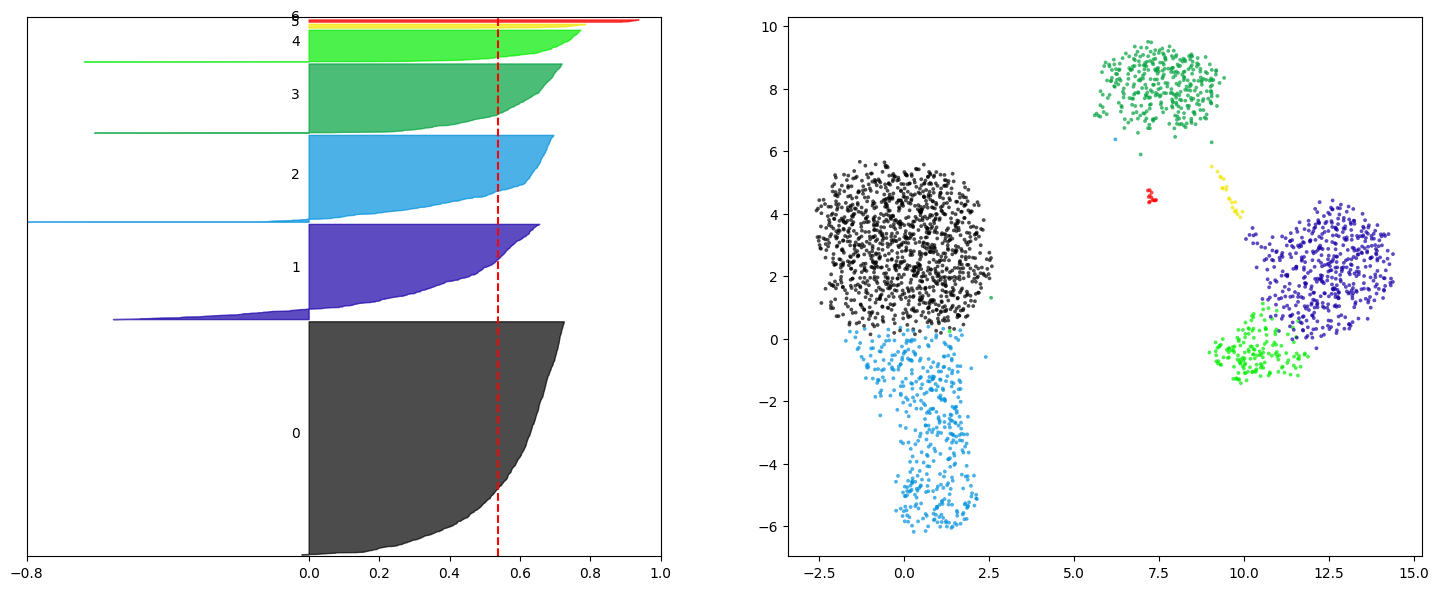

For n_clusters = 6 The average silhouette_score is: 0.559248


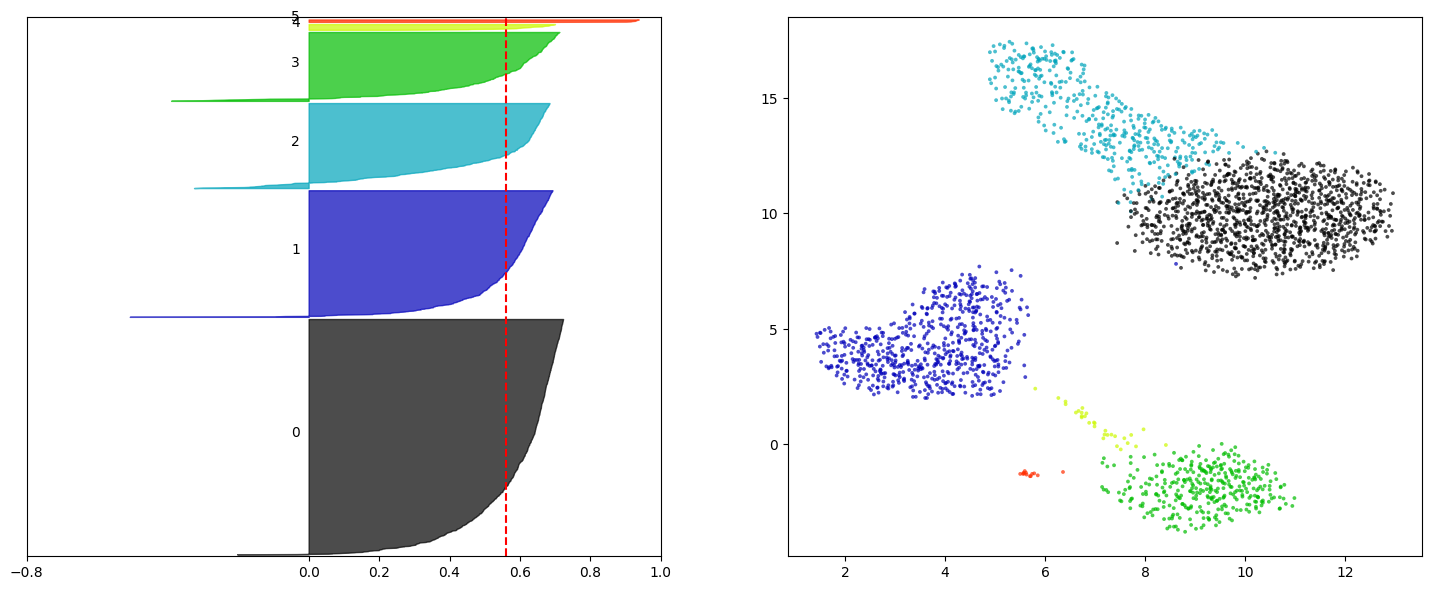

For n_clusters = 5 The average silhouette_score is: 0.59475887


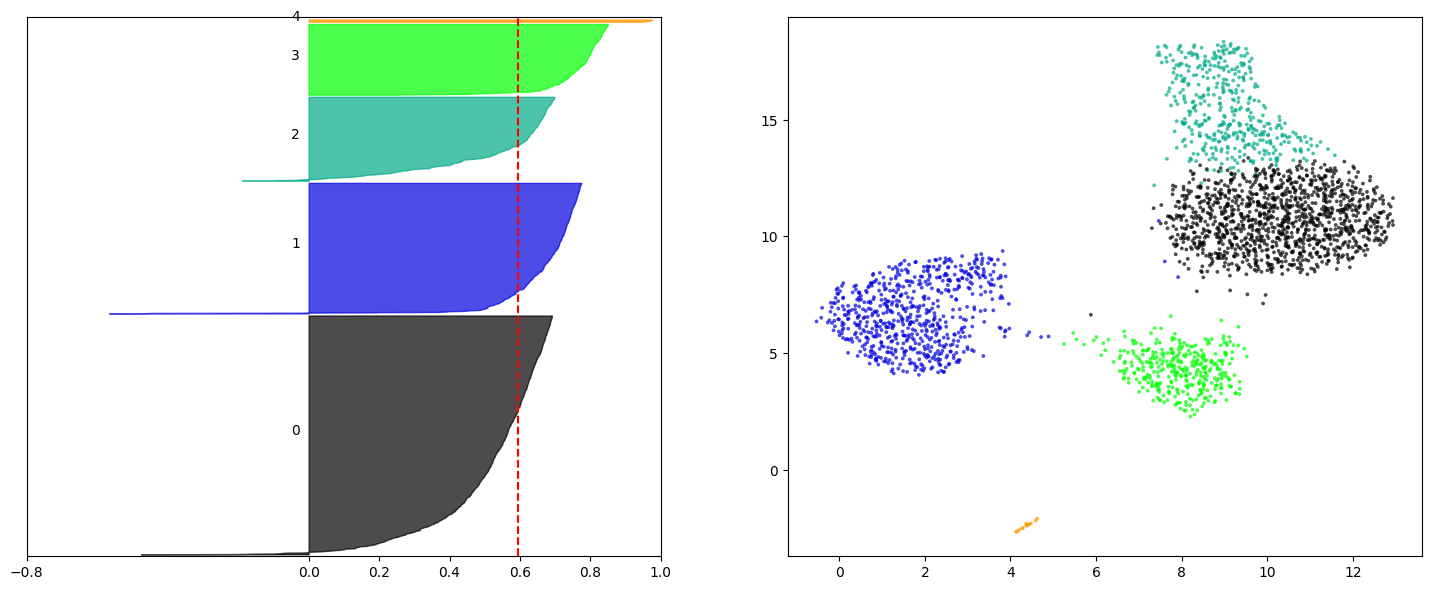

For n_clusters = 5 The average silhouette_score is: 0.5579158


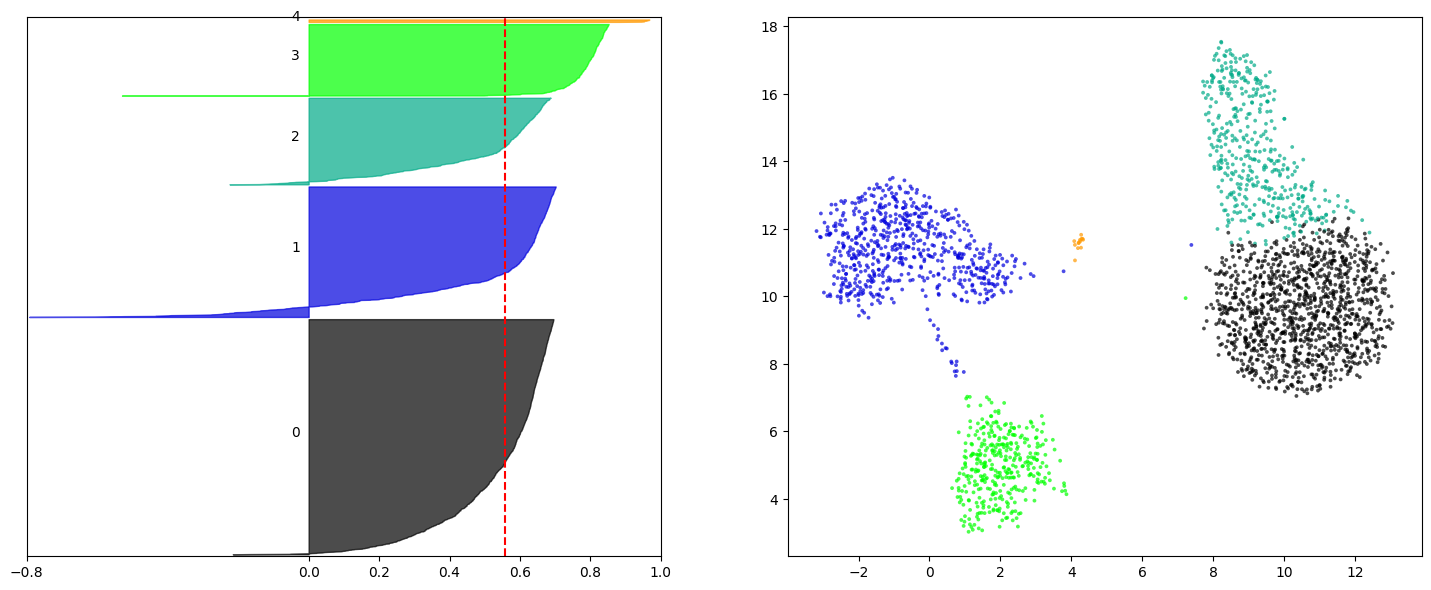

In [345]:
for seed in np.arange(0,20,1):
    
    torch.manual_seed(seed)
    
    FILE_VAE = f"model_VAE_seed{seed}.pth"
    FILE_AE  = f"model_AE_seed{seed}.pth"
    
    loaded_model_AE, loaded_model_VAE = ModelsNN(adata.X.shape[1],1024,40)
    
    loaded_model_AE.to(device)
    loaded_model_VAE.to(device)
    
    loaded_model_AE.load_state_dict(torch.load(FILE_AE, map_location=device))
    loaded_model_VAE.load_state_dict(torch.load(FILE_VAE, map_location=device))
    
    loaded_model_AE.eval()
    loaded_model_VAE.eval()
    
    _,_,_,adata_latent = loaded_model_VAE(adata_tensor)
    adata_latent_np = adata_latent.cpu().detach().numpy()
    adata.obsm["X_VAE"] = adata_latent_np

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_VAE")
    sc.tl.leiden(adata,resolution=0.6,)
    sc.tl.umap(adata)

    X = adata.obsm["X_umap"]
    cluster_labels = adata.obs["leiden"]
    if True: ### adapeded from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is:",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )

        plt.show()

/home/muellert/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


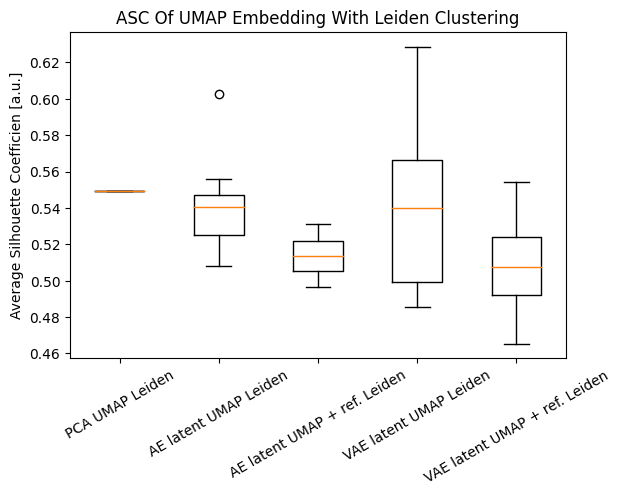

In [338]:
VAE_ASS = []
AE_ASS  = []
AE_ASS_PCA = []
VAE_ASS_PCA = []

adata = Load_preprocessed_data()
PCA_score = silhouette_score(adata.obsm["X_umap"], adata.obs["leiden_pca"])

for seed in np.arange(0,20,1):
    torch.manual_seed(seed)
    FILE_VAE = f"model_VAE_seed{seed}.pth"
    FILE_AE  = f"model_AE_seed{seed}.pth"
    
    loaded_model_AE, loaded_model_VAE = ModelsNN(adata.X.shape[1],1024,40)
    
    loaded_model_AE.to(device)
    loaded_model_VAE.to(device)
    
    loaded_model_AE.load_state_dict(torch.load(FILE_AE, map_location=device))
    loaded_model_VAE.load_state_dict(torch.load(FILE_VAE, map_location=device))
    
    loaded_model_AE.eval()
    loaded_model_VAE.eval()
    
    adata_latent_AE,_ = loaded_model_AE(adata_tensor)
    adata.obsm["X_AE"] = adata_latent_AE.cpu().detach().numpy()
    
    _,_,_, adata_latent_VAE = loaded_model_VAE(adata_tensor)
    adata.obsm["X_VAE"] = adata_latent_VAE.cpu().detach().numpy()

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_AE",key_added='neighbors_AE')
    sc.tl.leiden(adata,resolution=0.6,key_added="leiden_AE",neighbors_key="neighbors_AE")
    sc.tl.umap(adata, neighbors_key="neighbors_AE")
    
    AE_ASS.append(silhouette_score(adata.obsm["X_umap"], adata.obs["leiden_AE"]))
    AE_ASS_PCA.append(silhouette_score(adata.obsm["X_umap"], adata.obs["leiden_pca"]))
    
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_VAE",key_added='neighbors_VAE')
    sc.tl.leiden(adata,resolution=0.6,key_added="leiden_VAE",neighbors_key="neighbors_VAE")
    sc.tl.umap(adata, neighbors_key="neighbors_VAE")

    VAE_ASS.append(silhouette_score(adata.obsm["X_umap"], adata.obs["leiden_VAE"]))
    VAE_ASS_PCA.append(silhouette_score(adata.obsm["X_umap"], adata.obs["leiden_pca"])) 

plt.boxplot([PCA_score,AE_ASS,AE_ASS_PCA,VAE_ASS,VAE_ASS_PCA])
plt.xticks([1,2,3,4,5], ['PCA UMAP Leiden', 'AE latent UMAP Leiden', 'AE latent UMAP + ref. Leiden', "VAE latent UMAP Leiden", "VAE latent UMAP + ref. Leiden"])
plt.title("ASC Of UMAP Embedding With Leiden Clustering")
plt.xticks(rotation=30)
plt.ylabel("Average Silhouette Coefficien [a.u.]")
plt.subplots_adjust(bottom=0.2)
plt.savefig("AE_VAE_ASC_plot.png", dpi=300)
plt.show()

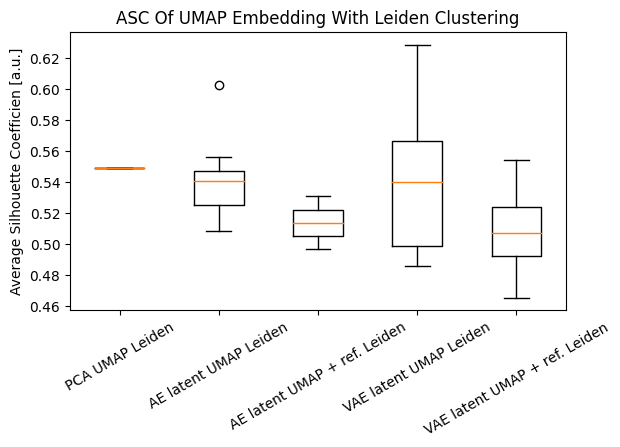

In [340]:
plt.boxplot([PCA_score,AE_ASS,AE_ASS_PCA,VAE_ASS,VAE_ASS_PCA])
plt.xticks([1,2,3,4,5], ['PCA UMAP Leiden', 'AE latent UMAP Leiden', 'AE latent UMAP + ref. Leiden', "VAE latent UMAP Leiden", "VAE latent UMAP + ref. Leiden"])
plt.title("ASC Of UMAP Embedding With Leiden Clustering")
plt.xticks(rotation=30)
plt.ylabel("Average Silhouette Coefficien [a.u.]")
plt.subplots_adjust(bottom=0.3)
plt.savefig("AE_VAE_ASC_plot.png", dpi=300)
plt.show()

In [341]:
[PCA_score,AE_ASS,AE_ASS_PCA,VAE_ASS,VAE_ASS_PCA]

[0.5491666,
 [0.5445303,
  0.54537266,
  0.5494578,
  0.556152,
  0.5411925,
  0.52003515,
  0.6023807,
  0.50815916,
  0.5522154,
  0.54647,
  0.5401701,
  0.5405952,
  0.528514,
  0.52550966,
  0.5529549,
  0.53790516,
  0.5360657,
  0.5209533,
  0.5247464,
  0.5203089],
 [0.50780094,
  0.52098215,
  0.5143597,
  0.50738084,
  0.5271502,
  0.51386964,
  0.51361984,
  0.52298707,
  0.5217526,
  0.5276837,
  0.49669597,
  0.52456063,
  0.5031847,
  0.50940996,
  0.4984525,
  0.53091395,
  0.52176994,
  0.4995238,
  0.50567615,
  0.5031032],
 [0.499933,
  0.54254365,
  0.4972083,
  0.49912727,
  0.5188013,
  0.5104056,
  0.6285784,
  0.5455917,
  0.4987693,
  0.4857968,
  0.48830318,
  0.552726,
  0.610524,
  0.58712214,
  0.60154593,
  0.49367177,
  0.5371019,
  0.559248,
  0.59475887,
  0.5579158],
 [0.53162473,
  0.5183035,
  0.52203196,
  0.5125104,
  0.5270042,
  0.49278966,
  0.5050571,
  0.5074965,
  0.5389067,
  0.46664315,
  0.49797615,
  0.49043974,
  0.5063589,
  0.5542962,
 

In [289]:
print(np.mean(AE_ASS),np.mean(AE_ASS_PCA),np.mean(VAE_ASS),np.mean(VAE_ASS_PCA))
print(np.median(AE_ASS),np.median(AE_ASS_PCA),np.median(VAE_ASS),np.median(VAE_ASS_PCA))
print(np.mean(np.abs(np.array(AE_ASS)-np.array(AE_ASS_PCA))),np.mean(np.abs(np.array(VAE_ASS)-np.array(VAE_ASS_PCA))))
print(np.median(np.abs(np.array(AE_ASS)-np.array(AE_ASS_PCA))),np.median(np.abs(np.array(VAE_ASS)-np.array(VAE_ASS_PCA))))

0.5396844 0.5135439 0.5404836 0.5076133
0.5403826 0.5137447 0.5398228 0.5074128
0.027623361 0.048604503
0.020249888 0.03225884


For n_clusters = 7 The average silhouette_score is (AE): 0.54254365


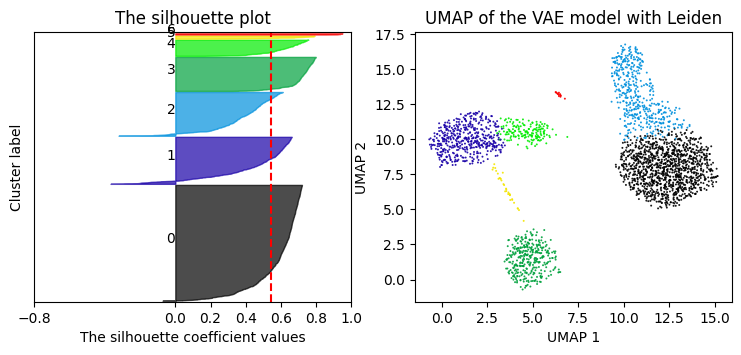

For n_clusters = 7 The average silhouette_score is (AE): 0.5183035


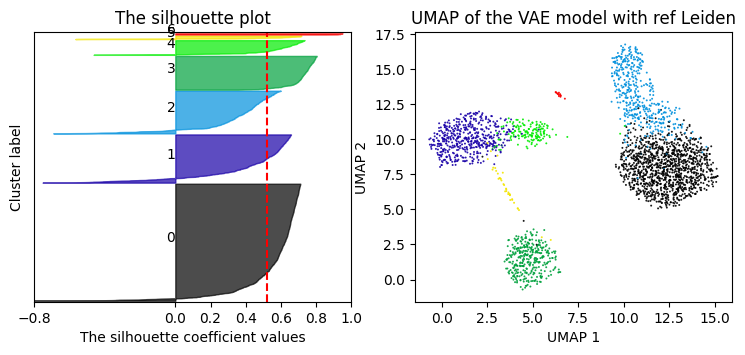

In [330]:
for seed in [1]:
    torch.manual_seed(seed)
    FILE_VAE = f"model_VAE_seed{seed}.pth"
    FILE_AE  = f"model_AE_seed{seed}.pth"
    
    loaded_model_AE, loaded_model_VAE = ModelsNN(adata.X.shape[1],1024,40)
    
    loaded_model_AE.to(device)
    loaded_model_VAE.to(device)
    
    loaded_model_AE.load_state_dict(torch.load(FILE_AE, map_location=device))
    loaded_model_VAE.load_state_dict(torch.load(FILE_VAE, map_location=device))
    
    loaded_model_AE.eval()
    loaded_model_VAE.eval()
    
    _,_,_,adata_latent = loaded_model_VAE(adata_tensor)
    adata_latent_np = adata_latent.cpu().detach().numpy()
    adata.obsm["X_AE"] = adata_latent_np

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_AE")
    sc.tl.leiden(adata,resolution=0.6,)
    sc.tl.umap(adata)
        
    marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                        'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                        'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

    X = adata.obsm["X_umap"]
    cluster_labels = adata.obs["leiden"]
    if True: #### based on https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(9, 3.5)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is (AE):",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], s=2, lw=0, alpha=0.9, c=colors, edgecolor="k",
            )



        ax2.set_title("UMAP of the VAE model with Leiden")
        ax2.set_xlabel("UMAP 1")
        ax2.set_ylabel("UMAP 2")


        
        plt.savefig("VAE_leiden.png", dpi=300)
        plt.show()
    cluster_labels = adata.obs["leiden_pca"]
    if True: ### adapeded from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden_pca"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(9, 3.5)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is (AE):",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], s=2, lw=0, alpha=0.9, c=colors, edgecolor="k",
            )



        ax2.set_title("UMAP of the VAE model with ref Leiden")
        ax2.set_xlabel("UMAP 1")
        ax2.set_ylabel("UMAP 2")




        plt.savefig("VAE_ref.png", dpi=300)
        plt.show()

For n_clusters = 7 The average silhouette_score is (AE): 0.54537266


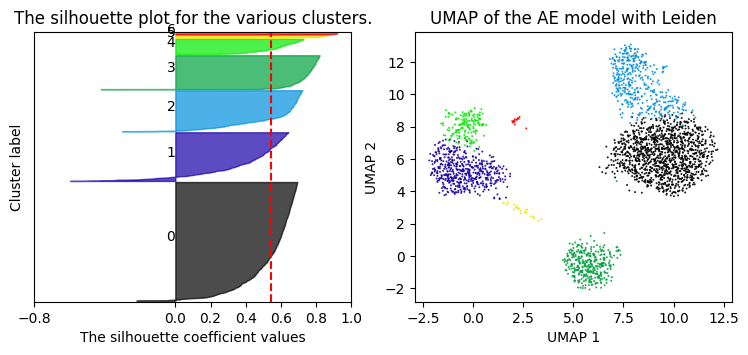

For n_clusters = 7 The average silhouette_score is (AE): 0.52098215


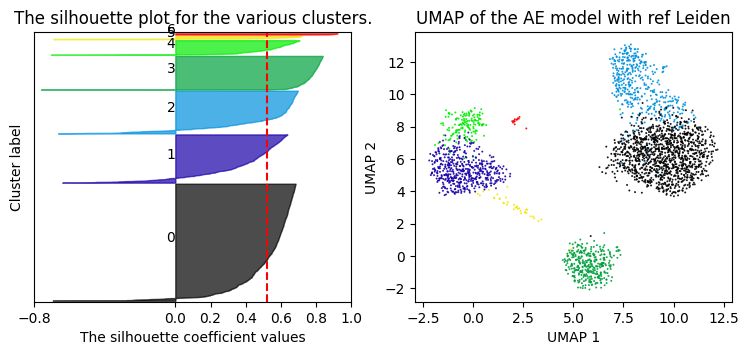

In [334]:
for seed in [1]:
    torch.manual_seed(seed)
    FILE_VAE = f"model_VAE_seed{seed}.pth"
    FILE_AE  = f"model_AE_seed{seed}.pth"
    
    loaded_model_AE, loaded_model_VAE = ModelsNN(adata.X.shape[1],1024,40)
    
    loaded_model_AE.to(device)
    loaded_model_VAE.to(device)
    
    loaded_model_AE.load_state_dict(torch.load(FILE_AE, map_location=device))
    loaded_model_VAE.load_state_dict(torch.load(FILE_VAE, map_location=device))
    
    loaded_model_AE.eval()
    loaded_model_VAE.eval()
    
    adata_latent,_ = loaded_model_AE(adata_tensor)
    adata_latent_np = adata_latent.cpu().detach().numpy()
    adata.obsm["X_AE"] = adata_latent_np

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_AE")
    sc.tl.leiden(adata,resolution=0.6,)
    sc.tl.umap(adata)
        
    marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                        'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                        'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

    X = adata.obsm["X_umap"]
    cluster_labels = adata.obs["leiden"]
    if True:
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(9, 3.5)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is (AE):",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], s=2, lw=0, alpha=0.9, c=colors, edgecolor="k"
            )

        ax2.set_title("UMAP of the AE model with Leiden")
        ax2.set_xlabel("UMAP 1")
        ax2.set_ylabel("UMAP 2")

        plt.savefig("AE.png", dpi=300)
        plt.show()
    cluster_labels = adata.obs["leiden_pca"]
    if True: ### adapeded from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden_pca"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(9, 3.5)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is (AE):",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], s=2, lw=0, alpha=0.9, c=colors, edgecolor="k"
            )

        ax2.set_title("UMAP of the AE model with ref Leiden")
        ax2.set_xlabel("UMAP 1")
        ax2.set_ylabel("UMAP 2")

        plt.savefig("AE_ref.png", dpi=300)
        plt.show()